### Safe deep Q-network

Have a network estimating $Q_w(s, a)$ for $-reward$, $Q^T_w(s, a)$ for stopping time $1$ iff terminal state, $Q^D_w(s, a)$ for constraint (the more the worse). $\pi$ is eps-soft of $Q$
1. Sample action and perform it
2. Sample minibatch from experience replay
3. Perform Bellman update: $\sum\limits_{s, a, r, s'}\left(r+\max_{a'}Q_{w_0}(s', a')-Q_w(s, a)\right)^2$

Networks: $Q_T, Q_D, Q, \pi$

Having collected experience D from the replay buffer:
1. Calculate current policy $\pi_k$ and Q-like functions (TensorFlow)
2. Calculate $\varepsilon$ using policy and $Q$s (TensorFlow)
3. Using policy, Q-functions and $\varepsilon$, solve LP to obtain $\pi'$ (SciPy)
4. Make a step for Bellman update using $\pi,\pi',\varepsilon,Q$ (TensorFlow)
5. Make a step towards minimizing $D_{JSD}(\pi||\pi')$ (TensorFlow)

In [1]:
#from xvfbwrapper import Xvfb

# for environ
import os, sys
# only using device 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
import tensorflow as tf

import datetime
from lyapunov_helpers import *
import gym
from gym import wrappers
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
# to display environment data
# see https://gist.github.com/thomelane/79e97630ba46c45985a946cae4805885
from IPython import display
%load_ext autoreload
%autoreload 2

In [ ]:
from lyapunov_model import *

In [ ]:
eps_decay = {0: 0.9, 300: 0.5, 300: 0.1, 400: 0}
#eps_decay = {0: 0.9, 300: 0., 1300: 0.1, 1500: 0}

In [ ]:
init_agent()

In [22]:
checkpoint()

Saved to ./2019-05-29 14:54:14.196090_0.ckpt


In [ ]:
#tf.train.Saver().save(sess, './cartpole-h1.ckpt')
#tf.train.Saver().restore(sess, './cartpole-h1.ckpt')

Parameters: {'sample_q': False, 'only_constraint': True, 'do_safe': False, 'learn_q': True, 'learn_policy': True, 'd0_': -1, 'L': 100, 'rollouts_per_train': 2, 'eps_decay': {0: 0.9, 300: 0.1, 400: 0}, 'iterations': 1000}


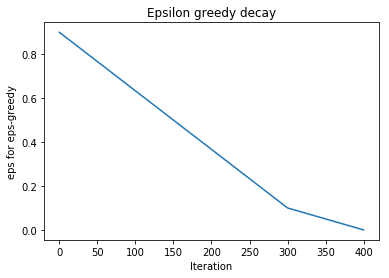

100%|██████████| 1000/1000 [00:53<00:00, 19.08it/s]


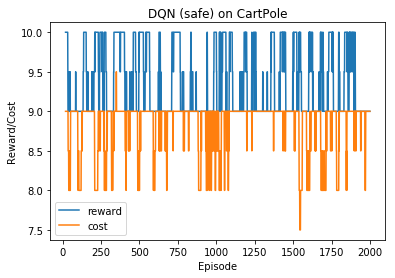

Mean action: 1.00
Total reward: 9
Total cost: 9


In [5]:
learning_iterations(1000, eps_decay, 2, L = 100, d0_ = -1, learn_policy = True, learn_q = True, do_safe = False,
                   only_constraint = True, sample_q = False)

In [16]:
# NEXT STEP: add mp4 of the agent

In [38]:
# Learning q-network
for i in tqdm(range(500)):
    # obtaining current epsilon for exploration
    #print('GetEps')
    eps = get_current_eps(eps_decay, i)
    
    #print('Rollouts')
    
    # obtaining rollout
    for i in range(2):
        sarsnc = get_rollout(eps = eps, sample_q = True)
        _, _, R, _, _, C = zip(*sarsnc)
        r.append(np.sum(R))
        c.append(np.sum(C))
        
    # training the agent
    train_step(L = 100, d0_ = 1000, learn_policy = False, learn_q = True, do_safe = False)
    #print(len(replay.buf))

100%|██████████| 500/500 [00:29<00:00, 17.23it/s]


In [86]:
sample_q = True # still sampling from Q to get behavior, but training pi
print(len(get_rollout()))

156


In [149]:
#tf.train.Saver().save(sess, './cartpole-sdqn1.ckpt')
tf.train.Saver().restore(sess, './cartpole-sdqn1.ckpt')

INFO:tensorflow:Restoring parameters from ./cartpole-sdqn1.ckpt


1. First, q-network can be trained on random+q policy using vanilla q-learning just to start w/o safety
2. Next, policy is trained to mimick q-learning
3. After, agent is switched to the policy
4. here there is a problem because q-values are not realistic. They are updated
5. Safety is turned on and the agent relearns

In [95]:
# why reward is bigger than it seems?..

In [97]:
# Training POLICY to behave somewhat well
for i in tqdm(range(500)):
    # obtaining current epsilon for exploration
    #print('GetEps')
    #eps = get_current_eps(eps_decay, i)
    
    #print('Rollouts')
        
    # training the agent
    # get some data
    print(len(get_rollout()))
    train_step(L = 100, d0_ = 1000, learn_policy = True, learn_q = False, do_safe = False)
    #print(len(replay.buf))

  1%|          | 3/500 [00:00<00:48, 10.32it/s]

200
182
122


  1%|          | 5/500 [00:00<00:45, 10.91it/s]

148
132
200


  2%|▏         | 8/500 [00:00<00:46, 10.48it/s]

150
200


  2%|▏         | 10/500 [00:00<00:47, 10.40it/s]

200
200
200


  3%|▎         | 13/500 [00:01<00:46, 10.36it/s]

161
200


  3%|▎         | 16/500 [00:01<00:47, 10.27it/s]

194
187
200
134


  4%|▎         | 18/500 [00:01<00:45, 10.59it/s]

200
140
148


  4%|▍         | 22/500 [00:01<00:42, 11.16it/s]

130
200
200


  5%|▍         | 24/500 [00:02<00:43, 11.04it/s]

133
132
200


  6%|▌         | 28/500 [00:02<00:40, 11.70it/s]

151
128
147


  6%|▌         | 30/500 [00:02<00:40, 11.47it/s]

200
192
184


  7%|▋         | 34/500 [00:03<00:40, 11.37it/s]

153
163
161


  7%|▋         | 36/500 [00:03<00:40, 11.35it/s]

200
200


  8%|▊         | 38/500 [00:03<00:42, 10.85it/s]

200
200
200


  8%|▊         | 42/500 [00:03<00:41, 10.92it/s]

200
140
199


  9%|▉         | 44/500 [00:03<00:42, 10.83it/s]

200
200
200


 10%|▉         | 48/500 [00:04<00:40, 11.14it/s]

148
124
172


 10%|█         | 50/500 [00:04<00:40, 11.00it/s]

200
200
157


 11%|█         | 54/500 [00:04<00:40, 10.99it/s]

200
182
197


 11%|█         | 56/500 [00:05<00:40, 10.87it/s]

200
166
200


 12%|█▏        | 60/500 [00:05<00:40, 10.95it/s]

158
200
151


 12%|█▏        | 62/500 [00:05<00:39, 11.03it/s]

200
200
148


 13%|█▎        | 66/500 [00:05<00:38, 11.36it/s]

200
142
200


 14%|█▎        | 68/500 [00:06<00:38, 11.33it/s]

148
200
154


 14%|█▍        | 72/500 [00:06<00:39, 10.84it/s]

200
190
200


 15%|█▍        | 74/500 [00:06<00:40, 10.57it/s]

200
200
146


 16%|█▌        | 78/500 [00:07<00:38, 10.88it/s]

147
200
200


 16%|█▌        | 80/500 [00:07<00:39, 10.65it/s]

200
141
200


 17%|█▋        | 84/500 [00:07<00:38, 10.75it/s]

200
188
162


 17%|█▋        | 86/500 [00:07<00:38, 10.86it/s]

200
166
174


 18%|█▊        | 90/500 [00:08<00:37, 10.88it/s]

181
200
199


 18%|█▊        | 92/500 [00:08<00:37, 10.84it/s]

200
200
200


 19%|█▉        | 96/500 [00:08<00:36, 11.02it/s]

187
158
187


 20%|█▉        | 98/500 [00:08<00:36, 11.01it/s]

200
161
200


 20%|██        | 102/500 [00:09<00:35, 11.08it/s]

141
172
129


 21%|██        | 104/500 [00:09<00:35, 11.11it/s]

197
154
144


 22%|██▏       | 108/500 [00:09<00:33, 11.65it/s]

142
137
194


 22%|██▏       | 110/500 [00:09<00:33, 11.78it/s]

125
143
161


 23%|██▎       | 114/500 [00:10<00:33, 11.62it/s]

200
144
145


 23%|██▎       | 116/500 [00:10<00:33, 11.55it/s]

200
200
176


 24%|██▍       | 120/500 [00:10<00:32, 11.61it/s]

140
200
200


 24%|██▍       | 122/500 [00:10<00:33, 11.42it/s]

200
198
200


 25%|██▌       | 126/500 [00:11<00:32, 11.44it/s]

200
132
198


 26%|██▌       | 128/500 [00:11<00:33, 11.26it/s]

200
133
200


 26%|██▋       | 132/500 [00:11<00:31, 11.55it/s]

152
143
141


 27%|██▋       | 134/500 [00:12<00:32, 11.32it/s]

200
156
200


 28%|██▊       | 138/500 [00:12<00:32, 11.16it/s]

150
200
163


 28%|██▊       | 140/500 [00:12<00:31, 11.32it/s]

161
143
174


 29%|██▉       | 144/500 [00:12<00:30, 11.67it/s]

138
169
200


 29%|██▉       | 146/500 [00:13<00:31, 11.20it/s]

200
197
155


 30%|███       | 150/500 [00:13<00:31, 11.21it/s]

191
133
138


 31%|███       | 154/500 [00:13<00:28, 11.98it/s]

162
128
141


 31%|███       | 156/500 [00:13<00:29, 11.73it/s]

158
200
175


 32%|███▏      | 160/500 [00:14<00:29, 11.65it/s]

200
126
162


 32%|███▏      | 162/500 [00:14<00:29, 11.53it/s]

188
152
200


 33%|███▎      | 164/500 [00:14<00:29, 11.33it/s]

160
161
153


 34%|███▎      | 168/500 [00:15<00:29, 11.34it/s]

200
142
129


 34%|███▍      | 170/500 [00:15<00:28, 11.57it/s]

182
200
134


 35%|███▍      | 174/500 [00:15<00:29, 10.98it/s]

200
200
200


 36%|███▌      | 178/500 [00:15<00:28, 11.33it/s]

185
140
135


 36%|███▌      | 180/500 [00:16<00:28, 11.19it/s]

159
200
200


 36%|███▋      | 182/500 [00:16<00:28, 11.13it/s]

151
200
200


 37%|███▋      | 186/500 [00:16<00:27, 11.54it/s]

149
123
142


 38%|███▊      | 188/500 [00:16<00:26, 11.77it/s]

127
161
150


 38%|███▊      | 192/500 [00:17<00:25, 11.87it/s]

200
130
148


 39%|███▉      | 194/500 [00:17<00:26, 11.55it/s]

200
200
176


 40%|███▉      | 198/500 [00:17<00:26, 11.40it/s]

200
131
200


 40%|████      | 200/500 [00:17<00:26, 11.13it/s]

196
145
161


 41%|████      | 204/500 [00:18<00:25, 11.43it/s]

152
200
149


 41%|████      | 206/500 [00:18<00:25, 11.51it/s]

154
200
176


 42%|████▏     | 210/500 [00:18<00:25, 11.37it/s]

200
165
200


 42%|████▏     | 212/500 [00:18<00:25, 11.18it/s]

191
128
200


 43%|████▎     | 216/500 [00:19<00:25, 11.36it/s]

200
164
200


 44%|████▎     | 218/500 [00:19<00:25, 11.23it/s]

200
198
200


 44%|████▍     | 222/500 [00:19<00:25, 10.93it/s]

200
139
145


 45%|████▍     | 224/500 [00:19<00:24, 11.43it/s]

134
200
177


 46%|████▌     | 228/500 [00:20<00:23, 11.37it/s]

128
192
200


 46%|████▌     | 230/500 [00:20<00:24, 11.03it/s]

200
200
198


 47%|████▋     | 234/500 [00:20<00:23, 11.09it/s]

122
196
200


 47%|████▋     | 236/500 [00:21<00:24, 10.99it/s]

166
144
200


 48%|████▊     | 240/500 [00:21<00:23, 11.00it/s]

200
200
132


 48%|████▊     | 242/500 [00:21<00:22, 11.57it/s]

142
200
200


 49%|████▉     | 246/500 [00:21<00:21, 11.59it/s]

139
144
200


 50%|████▉     | 248/500 [00:22<00:22, 11.21it/s]

200
143
200


 50%|█████     | 252/500 [00:22<00:22, 10.94it/s]

200
200
200


 51%|█████     | 254/500 [00:22<00:21, 11.26it/s]

142
132
200


 52%|█████▏    | 258/500 [00:23<00:21, 11.00it/s]

200
200
133


 52%|█████▏    | 260/500 [00:23<00:21, 11.13it/s]

200
200
200


 53%|█████▎    | 264/500 [00:23<00:21, 10.92it/s]

200
154
143


 53%|█████▎    | 266/500 [00:23<00:20, 11.27it/s]

135
200
146


 54%|█████▍    | 270/500 [00:24<00:20, 11.11it/s]

195
200
184


 54%|█████▍    | 272/500 [00:24<00:19, 11.41it/s]

123
186
200


 55%|█████▌    | 276/500 [00:24<00:19, 11.24it/s]

148
200
156


 56%|█████▌    | 280/500 [00:24<00:18, 11.77it/s]

179
135
156


 56%|█████▋    | 282/500 [00:25<00:18, 11.71it/s]

134
200
151


 57%|█████▋    | 284/500 [00:25<00:18, 11.71it/s]

148
138
157


 58%|█████▊    | 288/500 [00:25<00:17, 12.20it/s]

128
121
129


 58%|█████▊    | 290/500 [00:25<00:17, 11.68it/s]

200
200
154


 59%|█████▉    | 294/500 [00:26<00:17, 11.73it/s]

138
134
159


 59%|█████▉    | 296/500 [00:26<00:17, 11.82it/s]

132
200
194


 60%|██████    | 300/500 [00:26<00:17, 11.68it/s]

132
132
200


 60%|██████    | 302/500 [00:26<00:16, 11.65it/s]

156
200
144


 61%|██████    | 306/500 [00:27<00:16, 11.72it/s]

200
134
175


 62%|██████▏   | 308/500 [00:27<00:16, 11.86it/s]

124
127
188


 62%|██████▏   | 312/500 [00:27<00:16, 11.72it/s]

200
154
173


 63%|██████▎   | 314/500 [00:27<00:16, 11.36it/s]

200
174
138


 64%|██████▎   | 318/500 [00:28<00:15, 11.64it/s]

200
144
126


 64%|██████▍   | 320/500 [00:28<00:15, 11.89it/s]

164
200
152


 65%|██████▍   | 324/500 [00:28<00:15, 11.13it/s]

200
200
172


 65%|██████▌   | 326/500 [00:28<00:15, 10.96it/s]

200
200
152


 66%|██████▌   | 330/500 [00:29<00:15, 10.74it/s]

200
200
151


 66%|██████▋   | 332/500 [00:29<00:15, 10.82it/s]

200
200
200


 67%|██████▋   | 336/500 [00:29<00:15, 10.91it/s]

200
148
200


 68%|██████▊   | 338/500 [00:30<00:14, 11.13it/s]

131
136
198


 68%|██████▊   | 342/500 [00:30<00:14, 11.15it/s]

162
200
200


 69%|██████▉   | 344/500 [00:30<00:13, 11.16it/s]

138
162
200


 70%|██████▉   | 348/500 [00:30<00:13, 11.45it/s]

144
132
139


 70%|███████   | 350/500 [00:31<00:12, 11.73it/s]

138
200
150


 71%|███████   | 354/500 [00:31<00:12, 11.36it/s]

138
200
200


 71%|███████   | 356/500 [00:31<00:12, 11.15it/s]

200
200
200


 72%|███████▏  | 360/500 [00:32<00:12, 11.01it/s]

162
200
136


 72%|███████▏  | 362/500 [00:32<00:12, 11.08it/s]

200
138
200


 73%|███████▎  | 366/500 [00:32<00:12, 10.96it/s]

200
190
134


 74%|███████▎  | 368/500 [00:32<00:11, 11.10it/s]

200
127
173


 74%|███████▍  | 372/500 [00:33<00:11, 11.12it/s]

176
200
200


 75%|███████▍  | 374/500 [00:33<00:11, 11.08it/s]

172
200
200


 76%|███████▌  | 378/500 [00:33<00:10, 11.13it/s]

164
171
200


 76%|███████▌  | 380/500 [00:33<00:11, 10.76it/s]

200
200
200


 77%|███████▋  | 384/500 [00:34<00:10, 10.93it/s]

147
142
200


 77%|███████▋  | 386/500 [00:34<00:10, 10.75it/s]

200
200
149


 78%|███████▊  | 390/500 [00:34<00:10, 10.89it/s]

145
200
168


 78%|███████▊  | 392/500 [00:34<00:09, 11.28it/s]

123
141
196


 79%|███████▉  | 396/500 [00:35<00:09, 11.33it/s]

143
159
152


 80%|███████▉  | 398/500 [00:35<00:09, 11.30it/s]

200
143
155


 80%|████████  | 402/500 [00:35<00:08, 11.38it/s]

200
153
200


 81%|████████  | 404/500 [00:35<00:08, 11.04it/s]

200
190
200


 82%|████████▏ | 408/500 [00:36<00:08, 10.94it/s]

160
200
161


 82%|████████▏ | 410/500 [00:36<00:08, 11.17it/s]

138
144
200


 83%|████████▎ | 414/500 [00:36<00:07, 11.19it/s]

148
200
181


 83%|████████▎ | 416/500 [00:37<00:07, 11.32it/s]

141
200
200


 84%|████████▍ | 420/500 [00:37<00:07, 11.08it/s]

200
153
123


 85%|████████▍ | 424/500 [00:37<00:06, 11.83it/s]

200
133
129


 85%|████████▌ | 426/500 [00:37<00:06, 11.54it/s]

147
200


 86%|████████▌ | 428/500 [00:38<00:06, 11.34it/s]

200
162
132


 86%|████████▌ | 430/500 [00:38<00:06, 11.45it/s]

200
200
200


 87%|████████▋ | 434/500 [00:38<00:06, 10.73it/s]

200
180
200


 87%|████████▋ | 436/500 [00:38<00:05, 11.11it/s]

133
200
200


 88%|████████▊ | 440/500 [00:39<00:05, 11.08it/s]

200
135
188


 88%|████████▊ | 442/500 [00:39<00:05, 10.87it/s]

200
200
148


 89%|████████▉ | 446/500 [00:39<00:04, 11.58it/s]

141
128
200


 90%|████████▉ | 448/500 [00:39<00:04, 11.16it/s]

199
149
200


 90%|█████████ | 452/500 [00:40<00:04, 10.93it/s]

200
197
200


 91%|█████████ | 454/500 [00:40<00:04, 10.59it/s]

200
149
177


 92%|█████████▏| 458/500 [00:40<00:03, 10.57it/s]

200
200


 92%|█████████▏| 460/500 [00:41<00:03, 10.75it/s]

200
148
152


 92%|█████████▏| 462/500 [00:41<00:03, 10.79it/s]

200
200
200


 93%|█████████▎| 466/500 [00:41<00:03, 10.75it/s]

187
200
200


 94%|█████████▎| 468/500 [00:41<00:02, 10.97it/s]

137
200
200


 94%|█████████▍| 472/500 [00:42<00:02, 10.42it/s]

200
200
153


 95%|█████████▍| 474/500 [00:42<00:02, 10.58it/s]

200
200
163


 96%|█████████▌| 478/500 [00:42<00:01, 11.15it/s]

184
123
147


 96%|█████████▋| 482/500 [00:43<00:01, 11.42it/s]

200
150
141


 97%|█████████▋| 484/500 [00:43<00:01, 11.55it/s]

128
200
199


 97%|█████████▋| 486/500 [00:43<00:01, 11.35it/s]

166
200
200


 98%|█████████▊| 490/500 [00:43<00:00, 11.26it/s]

200
146
200


 98%|█████████▊| 492/500 [00:43<00:00, 10.98it/s]

186
130
200


 99%|█████████▉| 496/500 [00:44<00:00, 11.25it/s]

137
200
155


100%|█████████▉| 498/500 [00:44<00:00, 11.26it/s]

200
200
200


100%|██████████| 500/500 [00:44<00:00, 10.99it/s]


In [104]:
# checkpoint, performance should be the same
print(len(get_rollout()))

140


In [115]:
# sample from Q function? NO, testing the policy...
sample_q = False

# FINAL PERFORMANCE
print(len(get_rollout()))

155


In [152]:
#tf.train.Saver().save(sess, './cartpole-sdqn2.ckpt')
tf.train.Saver().restore(sess, './cartpole-sdqn2.ckpt')

INFO:tensorflow:Restoring parameters from ./cartpole-sdqn2.ckpt


In [154]:
# sample from Q function? YES, learning safe...
sample_q = True

# checkpoint
print(len(get_rollout()))

200


In [155]:
# sample from Q function? YES, learning safe...
sample_q = False

# checkpoint
print(len(get_rollout()))

151


In [156]:
# Issue: learning P+Q destroys performance... Why?..

In [159]:
# now, learning the q-values...
for i in tqdm(range(5000)):
    # obtaining current epsilon for exploration
    #print('GetEps')
    #eps = get_current_eps(eps_decay, i)
    
    #print('Rollouts')
        
    # training the agent
    # get some data
    print(len(get_rollout()))
    train_step(L = 100, d0_ = 201, learn_policy = True, learn_q = True, do_safe = False)
    #print(len(replay.buf)


  0%|          | 0/5000 [00:00<?, ?it/s]/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less

  0%|          | 3/5000 [00:00<03:56, 21.15it/s]

10
9
11
10
10



  0%|          | 9/5000 [00:00<03:52, 21.47it/s]

10
10
8
9
9



  0%|          | 12/5000 [00:00<03:53, 21.38it/s]

9
10
8
9
9



  0%|          | 18/5000 [00:00<03:51, 21.52it/s]

10
10
9
8
9



  0%|          | 24/5000 [00:01<03:49, 21.70it/s]

10
8
9
10
9



  1%|          | 27/5000 [00:01<03:48, 21.73it/s]

10
9
9
10
10



  1%|          | 33/5000 [00:01<03:48, 21.70it/s]

10
10
10
9
8



  1%|          | 39/5000 [00:01<03:47, 21.85it/s]

10
8
8
9
10



  1%|          | 42/5000 [00:01<03:46, 21.86it/s]

9
10
10
10
8



  1%|          | 48/5000 [00:02<03:50, 21.50it/s]

10
8
9
8
8



  1%|          | 54/5000 [00:02<03:48, 21.65it/s]

9
8
9
10
9



  1%|          | 57/5000 [00:02<03:48, 21.62it/s]

10
8
9
11
9



  1%|▏         | 63/5000 [00:02<03:46, 21.76it/s]

9
8
11
10
9



  1%|▏         | 69/5000 [00:03<03:46, 21.73it/s]

10
10
9
9
9



  1%|▏         | 72/5000 [00:03<03:47, 21.67it/s]

10
9
10
9
10



  2%|▏         | 78/5000 [00:03<03:45, 21.83it/s]

10
10
10
10
10



  2%|▏         | 84/5000 [00:03<03:46, 21.69it/s]

9
9
9
10
9



  2%|▏         | 87/5000 [00:04<03:46, 21.70it/s]

9
9
9
10
8



  2%|▏         | 93/5000 [00:04<03:46, 21.67it/s]

10
10
9
10
9



  2%|▏         | 99/5000 [00:04<03:46, 21.62it/s]

9
9
11
10
8



  2%|▏         | 102/5000 [00:04<03:45, 21.74it/s]

9
8
9
10
8



  2%|▏         | 108/5000 [00:04<03:46, 21.63it/s]

10
9
10
10
9



  2%|▏         | 114/5000 [00:05<03:47, 21.46it/s]

10
11
8
10
9



  2%|▏         | 117/5000 [00:05<03:46, 21.56it/s]

8
10
9
10
10



  2%|▏         | 123/5000 [00:05<03:46, 21.56it/s]

10
9
10
10
9



  3%|▎         | 129/5000 [00:05<03:44, 21.70it/s]

10
9
8
9
8



  3%|▎         | 132/5000 [00:06<03:44, 21.67it/s]

10
9
9
9
10



  3%|▎         | 138/5000 [00:06<03:45, 21.57it/s]

9
9
11
9
11



  3%|▎         | 144/5000 [00:06<03:45, 21.52it/s]

10
9
9
10
8



  3%|▎         | 147/5000 [00:06<03:44, 21.64it/s]

9
9
10
10
10



  3%|▎         | 153/5000 [00:07<03:43, 21.68it/s]

9
9
9
10
10



  3%|▎         | 159/5000 [00:07<03:42, 21.77it/s]

10
9
9
10
10



  3%|▎         | 162/5000 [00:07<03:42, 21.79it/s]

9
9
11
9
10



  3%|▎         | 168/5000 [00:07<03:43, 21.67it/s]

11
9
10
9
10



  3%|▎         | 174/5000 [00:08<03:41, 21.77it/s]

8
10
10
10
8



  4%|▎         | 177/5000 [00:08<03:41, 21.81it/s]

9
9
10
9
9



  4%|▎         | 183/5000 [00:08<03:40, 21.82it/s]

8
9
8
10
10



  4%|▍         | 189/5000 [00:08<03:40, 21.81it/s]

10
10
9
10
8



  4%|▍         | 192/5000 [00:08<03:39, 21.86it/s]

8
8
10
10
10



  4%|▍         | 198/5000 [00:09<03:38, 22.02it/s]

9
8
8
9
9



  4%|▍         | 204/5000 [00:09<03:38, 21.91it/s]

10
10
10
9
9



  4%|▍         | 207/5000 [00:09<03:38, 21.93it/s]

9
10
9
10
8



  4%|▍         | 213/5000 [00:09<03:38, 21.91it/s]

10
9
8
8
10



  4%|▍         | 219/5000 [00:10<03:43, 21.37it/s]

9
10
10
9
10



  4%|▍         | 222/5000 [00:10<03:41, 21.53it/s]

9
9
10
9
8



  5%|▍         | 228/5000 [00:10<03:41, 21.53it/s]

10
11
9
11
9



  5%|▍         | 234/5000 [00:10<03:40, 21.57it/s]

11
9
8
10
9



  5%|▍         | 237/5000 [00:10<03:39, 21.69it/s]

8
10
8
10
9



  5%|▍         | 243/5000 [00:11<03:39, 21.67it/s]

9
10
9
8
9



  5%|▍         | 249/5000 [00:11<03:38, 21.76it/s]

8
9
10
8
9



  5%|▌         | 252/5000 [00:11<03:38, 21.71it/s]

8
10
10
10
9



  5%|▌         | 258/5000 [00:11<03:39, 21.61it/s]

9
9
9
8
9



  5%|▌         | 264/5000 [00:12<03:37, 21.76it/s]

10
8
10
10
10



  5%|▌         | 267/5000 [00:12<03:38, 21.68it/s]

10
10
8
9
10



  5%|▌         | 273/5000 [00:12<03:36, 21.81it/s]

9
10
8
10
10



  6%|▌         | 279/5000 [00:12<03:36, 21.79it/s]

9
9
10
10
8



  6%|▌         | 282/5000 [00:12<03:35, 21.86it/s]

10
10
10
10
10



  6%|▌         | 288/5000 [00:13<03:35, 21.90it/s]

10
10
9
10
8



  6%|▌         | 294/5000 [00:13<03:35, 21.87it/s]

9
10
10
8
10



  6%|▌         | 297/5000 [00:13<03:35, 21.86it/s]

10
8
9
8
10



  6%|▌         | 303/5000 [00:13<03:35, 21.82it/s]

10
9
9
9
9



  6%|▌         | 309/5000 [00:14<03:35, 21.81it/s]

9
9
9
10
9



  6%|▌         | 312/5000 [00:14<03:36, 21.70it/s]

9
8
9
9
10



  6%|▋         | 318/5000 [00:14<03:35, 21.77it/s]

10
9
8
10
9



  6%|▋         | 324/5000 [00:14<03:36, 21.59it/s]

10
8
11
10
10



  7%|▋         | 327/5000 [00:15<03:39, 21.26it/s]

10
10
8
9
10



  7%|▋         | 333/5000 [00:15<03:35, 21.66it/s]

9
9
9
8
9



  7%|▋         | 339/5000 [00:15<03:33, 21.79it/s]

8
9
10
9
9



  7%|▋         | 342/5000 [00:15<03:33, 21.83it/s]

10
9
10
8
8



  7%|▋         | 348/5000 [00:16<03:34, 21.71it/s]

9
10
9
9
10



  7%|▋         | 354/5000 [00:16<03:35, 21.58it/s]

8
9
9
10
10



  7%|▋         | 357/5000 [00:16<03:36, 21.48it/s]

9
10
10
10
10



  7%|▋         | 363/5000 [00:16<03:34, 21.59it/s]

10
10
9
9
10



  7%|▋         | 369/5000 [00:17<03:33, 21.73it/s]

9
10
8
9
10



  7%|▋         | 372/5000 [00:17<03:33, 21.72it/s]

10
8
10
10
9



  8%|▊         | 378/5000 [00:17<03:31, 21.89it/s]

8
10
9
10
10



  8%|▊         | 384/5000 [00:17<03:31, 21.83it/s]

10
10
8
10
9



  8%|▊         | 387/5000 [00:17<03:35, 21.44it/s]

10
10
8
10
8



  8%|▊         | 393/5000 [00:18<03:33, 21.53it/s]

10
9
10
10
9



  8%|▊         | 399/5000 [00:18<03:32, 21.62it/s]

8
10
9
10
10



  8%|▊         | 402/5000 [00:18<03:33, 21.49it/s]

11
10
9
9
8



  8%|▊         | 408/5000 [00:18<03:31, 21.68it/s]

9
8
10
9
9



  8%|▊         | 414/5000 [00:19<03:31, 21.70it/s]

11
10
9
10
9



  8%|▊         | 417/5000 [00:19<03:30, 21.81it/s]

9
8
10
10
10



  8%|▊         | 423/5000 [00:19<03:30, 21.76it/s]

8
9
8
9
8



  9%|▊         | 429/5000 [00:19<03:29, 21.77it/s]

9
9
10
10
9



  9%|▊         | 432/5000 [00:19<03:29, 21.79it/s]

10
9
10
10
10



  9%|▉         | 438/5000 [00:20<03:46, 20.16it/s]

10
11
10
10



  9%|▉         | 441/5000 [00:20<03:41, 20.55it/s]

10
9
10
9
8



  9%|▉         | 447/5000 [00:20<03:34, 21.22it/s]

10
10
10
9
9



  9%|▉         | 453/5000 [00:20<03:31, 21.48it/s]

9
10
9
9
9



  9%|▉         | 456/5000 [00:21<03:30, 21.56it/s]

9
11
11
9
9



  9%|▉         | 462/5000 [00:21<03:29, 21.62it/s]

11
9
10
10
10



  9%|▉         | 468/5000 [00:21<03:29, 21.64it/s]

9
8
9
10
8



  9%|▉         | 471/5000 [00:21<03:28, 21.68it/s]

10
10
9
10
10



 10%|▉         | 477/5000 [00:22<03:29, 21.58it/s]

10
10
9
10
9



 10%|▉         | 483/5000 [00:22<03:28, 21.71it/s]

8
8
9
9
9



 10%|▉         | 486/5000 [00:22<03:27, 21.70it/s]

9
10
8
10
8



 10%|▉         | 492/5000 [00:22<03:27, 21.73it/s]

10
11
10
10
8



 10%|▉         | 498/5000 [00:22<03:27, 21.65it/s]

9
10
9
9
10



 10%|█         | 501/5000 [00:23<03:28, 21.54it/s]

10
9
8
9
9



 10%|█         | 507/5000 [00:23<03:28, 21.57it/s]

10
10
10
8
9



 10%|█         | 513/5000 [00:23<03:27, 21.61it/s]

10
9
9
10
10



 10%|█         | 516/5000 [00:23<03:27, 21.57it/s]

10
9
9
8
10



 10%|█         | 522/5000 [00:24<03:26, 21.67it/s]

9
9
9
10
10



 11%|█         | 528/5000 [00:24<03:27, 21.56it/s]

10
11
9
10
9



 11%|█         | 531/5000 [00:24<03:26, 21.59it/s]

8
10
9
9
9



 11%|█         | 537/5000 [00:24<03:25, 21.69it/s]

9
9
9
10
10



 11%|█         | 543/5000 [00:25<03:27, 21.50it/s]

8
8
9
8
10



 11%|█         | 546/5000 [00:25<03:25, 21.67it/s]

9
8
10
9
9



 11%|█         | 552/5000 [00:25<03:24, 21.72it/s]

10
9
10
10
10



 11%|█         | 558/5000 [00:25<03:25, 21.57it/s]

8
11
9
9
10



 11%|█         | 561/5000 [00:25<03:24, 21.71it/s]

9
8
8
10
9



 11%|█▏        | 567/5000 [00:26<03:24, 21.73it/s]

10
10
10
10
10



 11%|█▏        | 573/5000 [00:26<03:24, 21.70it/s]

9
9
10
9
9



 12%|█▏        | 576/5000 [00:26<03:24, 21.63it/s]

10
8
9
10
9



 12%|█▏        | 582/5000 [00:26<03:23, 21.69it/s]

10
10
9
10
10



 12%|█▏        | 588/5000 [00:27<03:24, 21.61it/s]

10
9
9
9
8



 12%|█▏        | 591/5000 [00:27<03:24, 21.54it/s]

10
9
10
8
9



 12%|█▏        | 597/5000 [00:27<03:23, 21.59it/s]

10
9
9
10
10



 12%|█▏        | 603/5000 [00:27<03:21, 21.80it/s]

9
8
8
8
9



 12%|█▏        | 606/5000 [00:27<03:21, 21.85it/s]

9
10
10
8
9



 12%|█▏        | 612/5000 [00:28<03:20, 21.85it/s]

9
9
9
9
10



 12%|█▏        | 618/5000 [00:28<03:20, 21.83it/s]

9
10
10
8
8



 12%|█▏        | 621/5000 [00:28<03:20, 21.84it/s]

10
9
10
10
9



 13%|█▎        | 627/5000 [00:28<03:19, 21.88it/s]

9
10
8
10
9



 13%|█▎        | 633/5000 [00:29<03:20, 21.77it/s]

11
9
10
9
10



 13%|█▎        | 636/5000 [00:29<03:20, 21.72it/s]

9
10
8
9
11



 13%|█▎        | 642/5000 [00:29<03:19, 21.85it/s]

9
9
9
8
8



 13%|█▎        | 648/5000 [00:29<03:18, 21.90it/s]

9
8
8
9
10



 13%|█▎        | 651/5000 [00:30<03:18, 21.89it/s]

9
10
10
9
9



 13%|█▎        | 657/5000 [00:30<03:20, 21.65it/s]

10
8
9
10
9



 13%|█▎        | 663/5000 [00:30<03:19, 21.78it/s]

9
9
9
8
10



 13%|█▎        | 666/5000 [00:30<03:19, 21.72it/s]

9
9
10
9
10



 13%|█▎        | 672/5000 [00:31<03:18, 21.78it/s]

10
10
10
9
8



 14%|█▎        | 678/5000 [00:31<03:17, 21.87it/s]

9
9
10
9
10



 14%|█▎        | 681/5000 [00:31<03:17, 21.89it/s]

9
10
9
10
9



 14%|█▎        | 687/5000 [00:31<03:18, 21.75it/s]

9
9
9
10
9



 14%|█▍        | 693/5000 [00:31<03:17, 21.85it/s]

9
9
9
9
9



 14%|█▍        | 696/5000 [00:32<03:16, 21.87it/s]

9
10
10
8
9



 14%|█▍        | 702/5000 [00:32<03:16, 21.88it/s]

11
10
10
9
8



 14%|█▍        | 708/5000 [00:32<03:18, 21.59it/s]

9
10
10
10
10



 14%|█▍        | 711/5000 [00:32<03:18, 21.60it/s]

10
10
10
11
9



 14%|█▍        | 717/5000 [00:33<03:16, 21.74it/s]

9
9
9
9
9



 14%|█▍        | 723/5000 [00:33<03:16, 21.80it/s]

9
10
10
10
9



 15%|█▍        | 726/5000 [00:33<03:16, 21.78it/s]

8
10
9
10
10



 15%|█▍        | 732/5000 [00:33<03:17, 21.59it/s]

9
9
10
9
10



 15%|█▍        | 738/5000 [00:34<03:18, 21.52it/s]

9
10
10
8
9



 15%|█▍        | 741/5000 [00:34<03:17, 21.55it/s]

10
9
9
10
8



 15%|█▍        | 747/5000 [00:34<03:16, 21.61it/s]

10
10
9
9
10



 15%|█▌        | 753/5000 [00:34<03:16, 21.60it/s]

9
10
9
10
10



 15%|█▌        | 756/5000 [00:34<03:16, 21.64it/s]

10
9
9
8
9



 15%|█▌        | 762/5000 [00:35<03:16, 21.59it/s]

8
9
8
10
10



 15%|█▌        | 768/5000 [00:35<03:14, 21.72it/s]

10
9
9
9
8



 15%|█▌        | 771/5000 [00:35<03:15, 21.62it/s]

10
9
10
9
8



 16%|█▌        | 777/5000 [00:35<03:15, 21.58it/s]

9
9
9
10
10



 16%|█▌        | 783/5000 [00:36<03:14, 21.63it/s]

9
10
10
10
10



 16%|█▌        | 786/5000 [00:36<03:15, 21.59it/s]

10
8
11
10
10



 16%|█▌        | 792/5000 [00:36<03:13, 21.70it/s]

9
10
9
9
9



 16%|█▌        | 798/5000 [00:36<03:12, 21.77it/s]

9
9
10
10
9



 16%|█▌        | 801/5000 [00:36<03:12, 21.80it/s]

10
10
9
9
10



 16%|█▌        | 807/5000 [00:37<03:12, 21.75it/s]

9
9
10
9
9



 16%|█▋        | 813/5000 [00:37<03:12, 21.74it/s]

9
10
10
9
10



 16%|█▋        | 816/5000 [00:37<03:12, 21.73it/s]

9
10
9
8
9



 16%|█▋        | 822/5000 [00:37<03:11, 21.83it/s]

10
10
9
10
8



 17%|█▋        | 828/5000 [00:38<03:10, 21.85it/s]

9
9
9
10
9



 17%|█▋        | 831/5000 [00:38<03:11, 21.81it/s]

9
8
8
10
10



 17%|█▋        | 837/5000 [00:38<03:10, 21.83it/s]

8
10
10
10
10



 17%|█▋        | 843/5000 [00:38<03:10, 21.77it/s]

9
10
10
9
10



 17%|█▋        | 846/5000 [00:39<03:10, 21.76it/s]

9
10
9
10
9



 17%|█▋        | 852/5000 [00:39<03:10, 21.76it/s]

10
9
9
9
8



 17%|█▋        | 858/5000 [00:39<03:10, 21.71it/s]

10
10
8
9
8



 17%|█▋        | 861/5000 [00:39<03:10, 21.70it/s]

10
8
10
9
10



 17%|█▋        | 867/5000 [00:39<03:09, 21.76it/s]

9
9
10
10
10



 17%|█▋        | 873/5000 [00:40<03:12, 21.44it/s]

10
10
10
9
11



 18%|█▊        | 876/5000 [00:40<03:12, 21.46it/s]

10
10
8
10
10



 18%|█▊        | 882/5000 [00:40<03:10, 21.62it/s]

10
9
10
9
8



 18%|█▊        | 888/5000 [00:40<03:09, 21.67it/s]

9
8
11
10
10



 18%|█▊        | 891/5000 [00:41<03:10, 21.61it/s]

9
10
8
10
9



 18%|█▊        | 897/5000 [00:41<03:08, 21.80it/s]

10
9
9
10
10



 18%|█▊        | 903/5000 [00:41<03:07, 21.81it/s]

10
9
9
8
9



 18%|█▊        | 906/5000 [00:41<03:08, 21.75it/s]

9
10
9
10
10



 18%|█▊        | 912/5000 [00:42<03:07, 21.80it/s]

10
10
9
10
10



 18%|█▊        | 918/5000 [00:42<03:06, 21.85it/s]

10
9
9
10
10



 18%|█▊        | 921/5000 [00:42<03:07, 21.80it/s]

9
10
10
11
8



 19%|█▊        | 927/5000 [00:42<03:06, 21.81it/s]

9
9
10
9
10



 19%|█▊        | 933/5000 [00:43<03:08, 21.60it/s]

10
10
9
10
11



 19%|█▊        | 936/5000 [00:43<03:10, 21.30it/s]

11
10
10
10
8



 19%|█▉        | 942/5000 [00:43<03:09, 21.46it/s]

10
10
9
9
8



 19%|█▉        | 948/5000 [00:43<03:07, 21.66it/s]

8
9
10
9
9



 19%|█▉        | 951/5000 [00:43<03:07, 21.55it/s]

10
10
10
10
9



 19%|█▉        | 957/5000 [00:44<03:07, 21.57it/s]

8
11
9
10
10



 19%|█▉        | 963/5000 [00:44<03:06, 21.68it/s]

9
10
8
8
9



 19%|█▉        | 966/5000 [00:44<03:05, 21.71it/s]

9
8
10
10
10



 19%|█▉        | 972/5000 [00:44<03:05, 21.67it/s]

10
9
9
9
10



 20%|█▉        | 978/5000 [00:45<03:05, 21.66it/s]

10
9
10
10
8



 20%|█▉        | 981/5000 [00:45<03:05, 21.65it/s]

10
10
10
8
8



 20%|█▉        | 987/5000 [00:45<03:05, 21.61it/s]

10
10
8
10
10



 20%|█▉        | 993/5000 [00:45<03:05, 21.65it/s]

9
10
9
10
9



 20%|█▉        | 996/5000 [00:45<03:04, 21.71it/s]

10
9
9
10
10



 20%|██        | 1002/5000 [00:46<03:04, 21.72it/s]

10
8
9
10
9



 20%|██        | 1008/5000 [00:46<03:04, 21.64it/s]

10
10
10
9
10



 20%|██        | 1011/5000 [00:46<03:04, 21.64it/s]

9
10
9
10
9



 20%|██        | 1017/5000 [00:46<03:04, 21.57it/s]

8
10
10
9
9



 20%|██        | 1023/5000 [00:47<03:05, 21.47it/s]

10
10
9
10
10



 21%|██        | 1026/5000 [00:47<03:04, 21.53it/s]

8
10
10
10
9



 21%|██        | 1032/5000 [00:47<03:03, 21.62it/s]

10
8
9
10
8



 21%|██        | 1038/5000 [00:47<03:02, 21.66it/s]

9
10
8
10
9



 21%|██        | 1041/5000 [00:48<03:01, 21.78it/s]

9
10
9
10
10



 21%|██        | 1047/5000 [00:48<03:01, 21.74it/s]

10
10
10
9
10



 21%|██        | 1053/5000 [00:48<03:01, 21.74it/s]

9
8
10
9
9



 21%|██        | 1056/5000 [00:48<03:02, 21.64it/s]

8
9
11
10
10



 21%|██        | 1062/5000 [00:48<03:03, 21.51it/s]

10
9
11
10
9



 21%|██▏       | 1068/5000 [00:49<03:01, 21.61it/s]

9
9
10
8
9



 21%|██▏       | 1071/5000 [00:49<03:01, 21.67it/s]

10
11
10
10
9



 22%|██▏       | 1077/5000 [00:49<03:01, 21.61it/s]

9
9
10
10
10



 22%|██▏       | 1083/5000 [00:49<03:00, 21.65it/s]

8
9
9
9
10



 22%|██▏       | 1086/5000 [00:50<03:00, 21.68it/s]

9
9
10
10
9



 22%|██▏       | 1092/5000 [00:50<03:01, 21.57it/s]

11
9
9
10
9



 22%|██▏       | 1098/5000 [00:50<02:59, 21.69it/s]

9
8
10
10
9



 22%|██▏       | 1101/5000 [00:50<02:59, 21.73it/s]

8
10
9
10
9



 22%|██▏       | 1107/5000 [00:51<02:58, 21.86it/s]

9
9
8
9
10



 22%|██▏       | 1113/5000 [00:51<02:57, 21.85it/s]

9
10
9
10
10



 22%|██▏       | 1116/5000 [00:51<02:59, 21.68it/s]

9
9
10
9
10



 22%|██▏       | 1122/5000 [00:51<02:59, 21.64it/s]

9
9
10
9
9



 23%|██▎       | 1128/5000 [00:52<02:58, 21.73it/s]

10
10
9
10
10



 23%|██▎       | 1131/5000 [00:52<02:58, 21.68it/s]

10
10
10
9
9



 23%|██▎       | 1137/5000 [00:52<02:57, 21.72it/s]

11
9
10
10
9



 23%|██▎       | 1143/5000 [00:52<02:57, 21.75it/s]

9
9
9
9
9



 23%|██▎       | 1146/5000 [00:52<02:57, 21.71it/s]

10
10
10
10
9



 23%|██▎       | 1152/5000 [00:53<02:55, 21.91it/s]

8
10
8
10
9



 23%|██▎       | 1158/5000 [00:53<02:56, 21.75it/s]

8
10
10
8
9



 23%|██▎       | 1161/5000 [00:53<02:56, 21.73it/s]

10
10
10
9
10



 23%|██▎       | 1167/5000 [00:53<02:55, 21.81it/s]

9
10
9
9
9



 23%|██▎       | 1173/5000 [00:54<02:55, 21.77it/s]

10
10
9
9
10



 24%|██▎       | 1176/5000 [00:54<02:55, 21.78it/s]

10
9
10
9
9



 24%|██▎       | 1182/5000 [00:54<02:54, 21.84it/s]

8
9
10
10
9



 24%|██▍       | 1188/5000 [00:54<02:54, 21.86it/s]

11
8
9
10
10



 24%|██▍       | 1191/5000 [00:54<02:54, 21.83it/s]

10
9
10
10
8



 24%|██▍       | 1197/5000 [00:55<02:56, 21.55it/s]

10
9
9
10
9



 24%|██▍       | 1203/5000 [00:55<02:56, 21.57it/s]

8
8
8
8
8



 24%|██▍       | 1206/5000 [00:55<02:55, 21.67it/s]

9
10
10
11
9



 24%|██▍       | 1212/5000 [00:55<02:55, 21.62it/s]

10
10
10
8
9



 24%|██▍       | 1218/5000 [00:56<02:53, 21.77it/s]

9
10
9
10
9



 24%|██▍       | 1221/5000 [00:56<02:54, 21.66it/s]

10
10
10
9
8



 25%|██▍       | 1227/5000 [00:56<02:53, 21.71it/s]

9
9
10
9
9



 25%|██▍       | 1233/5000 [00:56<02:52, 21.87it/s]

8
8
9
9
10



 25%|██▍       | 1236/5000 [00:57<02:52, 21.87it/s]

9
8
8
11
10



 25%|██▍       | 1242/5000 [00:57<02:51, 21.89it/s]

11
8
9
10
10



 25%|██▍       | 1248/5000 [00:57<02:54, 21.46it/s]

9
9
8
9
10



 25%|██▌       | 1251/5000 [00:57<02:53, 21.55it/s]

9
9
10
9
9



 25%|██▌       | 1257/5000 [00:57<02:52, 21.76it/s]

8
8
8
9
9



 25%|██▌       | 1263/5000 [00:58<02:52, 21.71it/s]

9
9
8
10
8



 25%|██▌       | 1266/5000 [00:58<02:51, 21.75it/s]

9
8
9
10
10



 25%|██▌       | 1272/5000 [00:58<02:52, 21.60it/s]

9
10
10
9
10



 26%|██▌       | 1278/5000 [00:58<02:51, 21.71it/s]

8
9
8
9
9



 26%|██▌       | 1281/5000 [00:59<02:52, 21.59it/s]

11
9
9
9
10



 26%|██▌       | 1287/5000 [00:59<02:51, 21.65it/s]

10
10
10
10
10



 26%|██▌       | 1293/5000 [00:59<02:51, 21.64it/s]

11
10
9
9
9



 26%|██▌       | 1296/5000 [00:59<02:50, 21.72it/s]

10
10
9
9
10



 26%|██▌       | 1302/5000 [01:00<02:50, 21.73it/s]

9
9
9
10
9



 26%|██▌       | 1308/5000 [01:00<02:50, 21.62it/s]

10
8
10
9
9



 26%|██▌       | 1311/5000 [01:00<02:50, 21.59it/s]

10
10
9
10
10



 26%|██▋       | 1317/5000 [01:00<02:49, 21.67it/s]

8
10
10
9
10



 26%|██▋       | 1323/5000 [01:01<02:49, 21.70it/s]

10
11
9
10
9



 27%|██▋       | 1326/5000 [01:01<02:48, 21.81it/s]

10
9
10
10
10



 27%|██▋       | 1332/5000 [01:01<02:48, 21.81it/s]

9
10
10
10
10



 27%|██▋       | 1335/5000 [01:01<02:48, 21.76it/s]

9
9
9



 27%|██▋       | 1341/5000 [01:01<03:06, 19.67it/s]

9
9
10
9
10



 27%|██▋       | 1344/5000 [01:02<03:00, 20.22it/s]

8
11
9
9
9



 27%|██▋       | 1350/5000 [01:02<02:53, 21.02it/s]

9
8
10
10
9



 27%|██▋       | 1356/5000 [01:02<02:50, 21.37it/s]

10
9
8
10
9



 27%|██▋       | 1359/5000 [01:02<02:49, 21.48it/s]

9
9
10
9
10



 27%|██▋       | 1365/5000 [01:03<02:48, 21.60it/s]

9
9
9
9
10



 27%|██▋       | 1371/5000 [01:03<02:48, 21.56it/s]

10
10
10
10
9



 27%|██▋       | 1374/5000 [01:03<02:48, 21.58it/s]

9
8
10
9
10



 28%|██▊       | 1380/5000 [01:03<02:47, 21.59it/s]

10
9
8
9
10



 28%|██▊       | 1386/5000 [01:03<02:47, 21.59it/s]

10
10
9
9
8



 28%|██▊       | 1389/5000 [01:04<02:46, 21.69it/s]

9
9
9
9
9



 28%|██▊       | 1395/5000 [01:04<02:45, 21.81it/s]

9
9
10
10
10



 28%|██▊       | 1401/5000 [01:04<02:46, 21.68it/s]

9
9
10
10
10



 28%|██▊       | 1404/5000 [01:04<02:45, 21.67it/s]

9
10
10
11
9



 28%|██▊       | 1410/5000 [01:05<02:44, 21.84it/s]

9
9
10
10
8



 28%|██▊       | 1416/5000 [01:05<02:46, 21.54it/s]

10
8
9
9
9



 28%|██▊       | 1419/5000 [01:05<02:45, 21.58it/s]

9
9
9
9
10



 28%|██▊       | 1425/5000 [01:05<02:46, 21.43it/s]

10
10
11
10
9



 29%|██▊       | 1431/5000 [01:06<02:45, 21.55it/s]

10
10
9
10
9



 29%|██▊       | 1434/5000 [01:06<02:45, 21.58it/s]

10
10
10
9
10



 29%|██▉       | 1440/5000 [01:06<02:44, 21.67it/s]

10
9
10
10
9



 29%|██▉       | 1446/5000 [01:06<02:43, 21.69it/s]

8
10
9
10
11



 29%|██▉       | 1449/5000 [01:06<02:43, 21.70it/s]

10
8
9
9
10



 29%|██▉       | 1455/5000 [01:07<02:43, 21.65it/s]

10
10
10
8
8



 29%|██▉       | 1461/5000 [01:07<02:43, 21.63it/s]

10
10
8
10
11



 29%|██▉       | 1464/5000 [01:07<02:42, 21.73it/s]

9
8
9
10
8



 29%|██▉       | 1470/5000 [01:07<02:42, 21.76it/s]

9
10
10
9
10



 30%|██▉       | 1476/5000 [01:08<02:41, 21.78it/s]

10
10
10
9
10



 30%|██▉       | 1479/5000 [01:08<02:42, 21.67it/s]

10
9
9
9
8



 30%|██▉       | 1485/5000 [01:08<02:44, 21.41it/s]

11
9
10
9
10



 30%|██▉       | 1491/5000 [01:08<02:42, 21.62it/s]

9
11
9
10
9



 30%|██▉       | 1494/5000 [01:08<02:42, 21.62it/s]

10
9
10
10
9



 30%|███       | 1500/5000 [01:09<02:40, 21.75it/s]

9
9
9
8
9



 30%|███       | 1506/5000 [01:09<02:39, 21.95it/s]

9
10
8
9
10



 30%|███       | 1509/5000 [01:09<02:39, 21.87it/s]

9
9
10
10
10



 30%|███       | 1515/5000 [01:09<02:40, 21.72it/s]

10
10
10
10
10



 30%|███       | 1521/5000 [01:10<02:42, 21.46it/s]

10
10
8
10
9



 30%|███       | 1524/5000 [01:10<02:41, 21.47it/s]

9
9
8
10
11



 31%|███       | 1530/5000 [01:10<02:40, 21.60it/s]

10
10
9
9
9



 31%|███       | 1536/5000 [01:10<02:40, 21.53it/s]

9
8
9
9
9



 31%|███       | 1539/5000 [01:11<02:40, 21.55it/s]

10
10
10
9
9



 31%|███       | 1545/5000 [01:11<02:39, 21.65it/s]

9
9
10
8
9



 31%|███       | 1551/5000 [01:11<02:40, 21.55it/s]

10
10
9
9
9



 31%|███       | 1554/5000 [01:11<02:39, 21.66it/s]

8
9
9
9
10



 31%|███       | 1560/5000 [01:12<02:38, 21.69it/s]

10
10
9
9
10



 31%|███▏      | 1566/5000 [01:12<02:37, 21.74it/s]

8
9
10
10
10



 31%|███▏      | 1569/5000 [01:12<02:37, 21.76it/s]

9
9
10
9
8



 32%|███▏      | 1575/5000 [01:12<02:38, 21.63it/s]

8
10
10
9
9



 32%|███▏      | 1581/5000 [01:12<02:37, 21.72it/s]

10
8
9
9
9



 32%|███▏      | 1584/5000 [01:13<02:36, 21.76it/s]

10
8
8
9
9



 32%|███▏      | 1590/5000 [01:13<02:36, 21.76it/s]

10
9
9
10
10



 32%|███▏      | 1596/5000 [01:13<02:36, 21.70it/s]

10
9
9
9
10



 32%|███▏      | 1599/5000 [01:13<02:36, 21.68it/s]

9
10
9
9
10



 32%|███▏      | 1605/5000 [01:14<02:36, 21.65it/s]

10
10
10
10
9



 32%|███▏      | 1611/5000 [01:14<02:36, 21.60it/s]

10
9
10
10
9



 32%|███▏      | 1614/5000 [01:14<02:36, 21.67it/s]

9
9
10
9
10



 32%|███▏      | 1620/5000 [01:14<02:35, 21.75it/s]

10
9
9
9
10



 33%|███▎      | 1626/5000 [01:15<02:34, 21.84it/s]

8
8
9
9
9



 33%|███▎      | 1629/5000 [01:15<02:35, 21.61it/s]

8
9
9
9
9



 33%|███▎      | 1635/5000 [01:15<02:35, 21.70it/s]

8
8
10
9
11



 33%|███▎      | 1641/5000 [01:15<02:35, 21.62it/s]

9
9
9
10
10



 33%|███▎      | 1644/5000 [01:15<02:35, 21.64it/s]

10
9
9
10
10



 33%|███▎      | 1650/5000 [01:16<02:34, 21.70it/s]

8
9
10
9
10



 33%|███▎      | 1656/5000 [01:16<02:33, 21.79it/s]

9
9
9
9
10



 33%|███▎      | 1659/5000 [01:16<02:33, 21.82it/s]

9
8
9
9
10



 33%|███▎      | 1665/5000 [01:16<02:32, 21.82it/s]

9
9
8
9
8



 33%|███▎      | 1671/5000 [01:17<02:32, 21.78it/s]

10
8
10
10
9



 33%|███▎      | 1674/5000 [01:17<02:33, 21.72it/s]

10
10
9
10
10



 34%|███▎      | 1680/5000 [01:17<02:33, 21.65it/s]

10
9
10
11
8



 34%|███▎      | 1686/5000 [01:17<02:33, 21.64it/s]

9
9
9
10
9



 34%|███▍      | 1689/5000 [01:17<02:32, 21.70it/s]

9
8
9
10
9



 34%|███▍      | 1695/5000 [01:18<02:33, 21.58it/s]

9
10
8
9
9



 34%|███▍      | 1701/5000 [01:18<02:31, 21.77it/s]

8
8
9
10
11



 34%|███▍      | 1704/5000 [01:18<02:31, 21.81it/s]

8
8
10
9
9



 34%|███▍      | 1710/5000 [01:18<02:33, 21.50it/s]

10
10
10
10
10



 34%|███▍      | 1716/5000 [01:19<02:31, 21.66it/s]

10
9
9
11
10



 34%|███▍      | 1719/5000 [01:19<02:32, 21.58it/s]

10
10
8
9
9



 34%|███▍      | 1725/5000 [01:19<02:31, 21.56it/s]

10
9
9
8
11



 35%|███▍      | 1731/5000 [01:19<02:32, 21.48it/s]

9
9
10
8
10



 35%|███▍      | 1734/5000 [01:20<02:31, 21.55it/s]

9
8
10
10
9



 35%|███▍      | 1740/5000 [01:20<02:32, 21.42it/s]

11
9
10
10
10



 35%|███▍      | 1746/5000 [01:20<02:29, 21.71it/s]

9
10
9
10
9



 35%|███▍      | 1749/5000 [01:20<02:29, 21.73it/s]

8
10
10
10
9



 35%|███▌      | 1755/5000 [01:21<02:30, 21.63it/s]

9
9
9
10
11



 35%|███▌      | 1761/5000 [01:21<02:29, 21.70it/s]

9
9
9
8
10



 35%|███▌      | 1764/5000 [01:21<02:29, 21.57it/s]

9
10
9
9
9



 35%|███▌      | 1770/5000 [01:21<02:29, 21.56it/s]

10
9
10
11
10



 36%|███▌      | 1776/5000 [01:22<02:29, 21.58it/s]

10
9
8
9
10



 36%|███▌      | 1779/5000 [01:22<02:29, 21.61it/s]

10
10
8
10
9



 36%|███▌      | 1785/5000 [01:22<02:27, 21.74it/s]

10
8
9
10
8



 36%|███▌      | 1791/5000 [01:22<02:26, 21.92it/s]

8
8
9
9
9



 36%|███▌      | 1794/5000 [01:22<02:26, 21.87it/s]

8
9
9
8
9



 36%|███▌      | 1800/5000 [01:23<02:27, 21.67it/s]

9
10
10
9
9



 36%|███▌      | 1806/5000 [01:23<02:27, 21.71it/s]

10
8
10
9
10



 36%|███▌      | 1809/5000 [01:23<02:27, 21.67it/s]

9
10
9
10
10



 36%|███▋      | 1815/5000 [01:23<02:27, 21.61it/s]

10
10
9
8
11



 36%|███▋      | 1821/5000 [01:24<02:27, 21.61it/s]

9
9
9
10
10



 36%|███▋      | 1824/5000 [01:24<02:27, 21.52it/s]

9
10
10
10
8



 37%|███▋      | 1830/5000 [01:24<02:28, 21.37it/s]

10
9
9
10
9



 37%|███▋      | 1836/5000 [01:24<02:27, 21.50it/s]

9
10
9
10
9



 37%|███▋      | 1839/5000 [01:24<02:27, 21.50it/s]

8
9
10
10
8



 37%|███▋      | 1845/5000 [01:25<02:25, 21.72it/s]

8
10
9
10
8



 37%|███▋      | 1851/5000 [01:25<02:26, 21.53it/s]

8
10
9
9
10



 37%|███▋      | 1854/5000 [01:25<02:26, 21.50it/s]

10
10
10
10
9



 37%|███▋      | 1860/5000 [01:25<02:25, 21.62it/s]

9
10
9
9
9



 37%|███▋      | 1866/5000 [01:26<02:25, 21.59it/s]

9
10
9
8
10



 37%|███▋      | 1869/5000 [01:26<02:26, 21.42it/s]

11
9
9
10
8



 38%|███▊      | 1875/5000 [01:26<02:25, 21.47it/s]

11
10
9
10
10



 38%|███▊      | 1881/5000 [01:26<02:24, 21.58it/s]

10
9
11
10
10



 38%|███▊      | 1884/5000 [01:27<02:24, 21.53it/s]

9
10
10
9
9



 38%|███▊      | 1890/5000 [01:27<02:25, 21.32it/s]

10
9
8
10
9



 38%|███▊      | 1896/5000 [01:27<02:25, 21.39it/s]

9
10
11
9
9



 38%|███▊      | 1899/5000 [01:27<02:24, 21.39it/s]

9
10
10
10
10



 38%|███▊      | 1905/5000 [01:27<02:24, 21.41it/s]

10
8
10
9
9



 38%|███▊      | 1911/5000 [01:28<02:22, 21.61it/s]

9
9
10
9
10



 38%|███▊      | 1914/5000 [01:28<02:23, 21.58it/s]

9
9
9
11
9



 38%|███▊      | 1920/5000 [01:28<02:22, 21.67it/s]

10
10
10
9
10



 39%|███▊      | 1926/5000 [01:28<02:21, 21.72it/s]

9
10
10
10
9



 39%|███▊      | 1929/5000 [01:29<02:20, 21.78it/s]

10
8
9
9
11



 39%|███▊      | 1935/5000 [01:29<02:20, 21.86it/s]

9
9
10
8
9



 39%|███▉      | 1941/5000 [01:29<02:19, 21.85it/s]

9
10
10
8
9



 39%|███▉      | 1944/5000 [01:29<02:20, 21.78it/s]

9
9
10
10
9



 39%|███▉      | 1950/5000 [01:30<02:21, 21.60it/s]

11
11
10
9
10



 39%|███▉      | 1956/5000 [01:30<02:22, 21.43it/s]

11
10
10
10
9



 39%|███▉      | 1959/5000 [01:30<02:21, 21.51it/s]

10
8
9
9
9



 39%|███▉      | 1965/5000 [01:30<02:21, 21.50it/s]

8
10
10
9
9



 39%|███▉      | 1971/5000 [01:31<02:21, 21.38it/s]

11
10
10
9
8



 39%|███▉      | 1974/5000 [01:31<02:20, 21.53it/s]

9
9
9
9
8



 40%|███▉      | 1980/5000 [01:31<02:19, 21.68it/s]

8
10
8
10
9



 40%|███▉      | 1986/5000 [01:31<02:19, 21.66it/s]

9
9
10
10
10



 40%|███▉      | 1989/5000 [01:31<02:18, 21.71it/s]

8
10
9
11
10



 40%|███▉      | 1995/5000 [01:32<02:19, 21.54it/s]

10
10
9
10
10



 40%|████      | 2001/5000 [01:32<02:18, 21.59it/s]

10
10
9
9
8



 40%|████      | 2004/5000 [01:32<02:17, 21.71it/s]

9
9
10
9
8



 40%|████      | 2010/5000 [01:32<02:17, 21.80it/s]

9
10
10
9
11



 40%|████      | 2016/5000 [01:33<02:16, 21.81it/s]

9
9
10
8
9



 40%|████      | 2019/5000 [01:33<02:16, 21.79it/s]

10
10
10
9
9



 40%|████      | 2025/5000 [01:33<02:16, 21.85it/s]

9
8
10
8
8



 41%|████      | 2031/5000 [01:33<02:15, 21.83it/s]

9
10
9
10
9



 41%|████      | 2034/5000 [01:33<02:15, 21.83it/s]

8
10
10
10
9



 41%|████      | 2040/5000 [01:34<02:16, 21.76it/s]

10
10
9
9
8



 41%|████      | 2046/5000 [01:34<02:15, 21.75it/s]

10
9
10
10
8



 41%|████      | 2049/5000 [01:34<02:15, 21.78it/s]

9
9
10
10
9



 41%|████      | 2055/5000 [01:34<02:15, 21.81it/s]

10
10
8
9
10



 41%|████      | 2061/5000 [01:35<02:14, 21.81it/s]

10
8
10
8
10



 41%|████▏     | 2064/5000 [01:35<02:16, 21.48it/s]

9
10
8
10
9



 41%|████▏     | 2070/5000 [01:35<02:16, 21.39it/s]

10
10
10
10
10



 42%|████▏     | 2076/5000 [01:35<02:15, 21.64it/s]

10
10
9
10
9



 42%|████▏     | 2079/5000 [01:36<02:15, 21.63it/s]

8
9
9
9
10



 42%|████▏     | 2085/5000 [01:36<02:13, 21.81it/s]

8
10
10
9
10



 42%|████▏     | 2091/5000 [01:36<02:12, 21.89it/s]

8
8
10
9
9



 42%|████▏     | 2094/5000 [01:36<02:13, 21.82it/s]

9
9
9
9
9



 42%|████▏     | 2100/5000 [01:36<02:13, 21.73it/s]

10
10
9
10
8



 42%|████▏     | 2106/5000 [01:37<02:13, 21.72it/s]

10
10
9
8
9



 42%|████▏     | 2109/5000 [01:37<02:12, 21.86it/s]

9
10
10
9
10



 42%|████▏     | 2115/5000 [01:37<02:12, 21.79it/s]

10
9
10
9
10



 42%|████▏     | 2121/5000 [01:37<02:12, 21.74it/s]

10
11
10
11
10



 42%|████▏     | 2124/5000 [01:38<02:12, 21.63it/s]

10
10
10
10
9



 43%|████▎     | 2130/5000 [01:38<02:12, 21.64it/s]

10
9
10
9
9



 43%|████▎     | 2136/5000 [01:38<02:12, 21.64it/s]

10
11
10
10
8



 43%|████▎     | 2139/5000 [01:38<02:12, 21.60it/s]

10
9
10
11
10



 43%|████▎     | 2145/5000 [01:39<02:12, 21.54it/s]

10
10
9
9
9



 43%|████▎     | 2151/5000 [01:39<02:11, 21.59it/s]

9
10
10
9
10



 43%|████▎     | 2154/5000 [01:39<02:12, 21.47it/s]

10
11
10
10
10



 43%|████▎     | 2160/5000 [01:39<02:11, 21.63it/s]

9
11
10
10
9



 43%|████▎     | 2166/5000 [01:40<02:10, 21.70it/s]

9
8
8
9
10



 43%|████▎     | 2169/5000 [01:40<02:10, 21.71it/s]

8
8
8
9
10



 44%|████▎     | 2175/5000 [01:40<02:11, 21.53it/s]

8
10
10
10
9



 44%|████▎     | 2181/5000 [01:40<02:10, 21.56it/s]

11
10
9
9
10



 44%|████▎     | 2184/5000 [01:40<02:10, 21.54it/s]

9
10
9
9
9



 44%|████▍     | 2190/5000 [01:41<02:09, 21.62it/s]

10
9
11
9
9



 44%|████▍     | 2196/5000 [01:41<02:08, 21.82it/s]

9
9
9
10
9



 44%|████▍     | 2199/5000 [01:41<02:08, 21.79it/s]

8
10
9
9
10



 44%|████▍     | 2205/5000 [01:41<02:07, 21.99it/s]

10
9
9
10
10



 44%|████▍     | 2211/5000 [01:42<02:08, 21.77it/s]

10
9
10
10
9



 44%|████▍     | 2214/5000 [01:42<02:07, 21.82it/s]

9
9
10
10
10



 44%|████▍     | 2220/5000 [01:42<02:08, 21.70it/s]

10
9
9
9
10



 45%|████▍     | 2226/5000 [01:42<02:08, 21.63it/s]

10
10
10
9
9



 45%|████▍     | 2229/5000 [01:42<02:08, 21.62it/s]

10
10
10
10
10



 45%|████▍     | 2235/5000 [01:43<02:08, 21.59it/s]

10
10
9
10
9



 45%|████▍     | 2241/5000 [01:43<02:08, 21.54it/s]

9
10
9
9
10



 45%|████▍     | 2244/5000 [01:43<02:07, 21.57it/s]

10
9
10
10
8



 45%|████▌     | 2250/5000 [01:43<02:07, 21.64it/s]

10
10
10
9
9



 45%|████▌     | 2256/5000 [01:44<02:08, 21.41it/s]

10
10
10
10
10



 45%|████▌     | 2259/5000 [01:44<02:07, 21.44it/s]

9
9
8
10
10



 45%|████▌     | 2265/5000 [01:44<02:07, 21.49it/s]

10
8
10
10
8



 45%|████▌     | 2271/5000 [01:44<02:06, 21.51it/s]

9
9
8
9
8



 45%|████▌     | 2274/5000 [01:45<02:06, 21.60it/s]

8
8
8
9
10



 46%|████▌     | 2277/5000 [01:45<02:05, 21.65it/s]


10
10
10


 46%|████▌     | 2283/5000 [01:45<02:18, 19.61it/s]

10
8
8
10
10



 46%|████▌     | 2289/5000 [01:45<02:10, 20.71it/s]

9
10
9
9
10



 46%|████▌     | 2292/5000 [01:45<02:10, 20.75it/s]

9
9
9
10
8



 46%|████▌     | 2298/5000 [01:46<02:07, 21.18it/s]

10
10
10
9
9



 46%|████▌     | 2304/5000 [01:46<02:06, 21.34it/s]

10
9
10
9
9



 46%|████▌     | 2307/5000 [01:46<02:05, 21.44it/s]

9
9
8
9
10



 46%|████▋     | 2313/5000 [01:46<02:05, 21.36it/s]

10
9
10
9
11



 46%|████▋     | 2319/5000 [01:47<02:04, 21.48it/s]

8
9
10
10
10



 46%|████▋     | 2322/5000 [01:47<02:04, 21.50it/s]

9
8
10
9
9



 47%|████▋     | 2328/5000 [01:47<02:03, 21.61it/s]

9
11
10
8
10



 47%|████▋     | 2334/5000 [01:47<02:02, 21.76it/s]

10
10
10
8
9



 47%|████▋     | 2337/5000 [01:48<02:02, 21.66it/s]

9
10
9
11
9



 47%|████▋     | 2343/5000 [01:48<02:02, 21.62it/s]

9
9
9
9
10



 47%|████▋     | 2349/5000 [01:48<02:02, 21.65it/s]

10
8
9
8
10



 47%|████▋     | 2352/5000 [01:48<02:02, 21.61it/s]

9
8
9
10
9



 47%|████▋     | 2358/5000 [01:48<02:01, 21.66it/s]

9
9
10
11
9



 47%|████▋     | 2364/5000 [01:49<02:01, 21.72it/s]

9
11
10
8
10



 47%|████▋     | 2367/5000 [01:49<02:01, 21.61it/s]

11
10
8
10
9



 47%|████▋     | 2373/5000 [01:49<02:01, 21.54it/s]

11
10
10
9
10



 48%|████▊     | 2379/5000 [01:49<02:01, 21.58it/s]

9
10
9
10
9



 48%|████▊     | 2382/5000 [01:50<02:01, 21.60it/s]

10
9
9
9
8



 48%|████▊     | 2388/5000 [01:50<02:02, 21.31it/s]

10
10
9
10
8



 48%|████▊     | 2391/5000 [01:50<02:05, 20.75it/s]

10
10
9
9



 48%|████▊     | 2397/5000 [01:50<02:10, 19.87it/s]

10
9
8
9
10



 48%|████▊     | 2403/5000 [01:51<02:06, 20.57it/s]

10
10
10
8
9



 48%|████▊     | 2406/5000 [01:51<02:04, 20.89it/s]

8
10
9
10
8



 48%|████▊     | 2412/5000 [01:51<02:01, 21.34it/s]

10
10
10
9
9



 48%|████▊     | 2418/5000 [01:51<02:00, 21.41it/s]

9
10
8
10
9



 48%|████▊     | 2421/5000 [01:51<02:00, 21.48it/s]

10
8
8
10
10



 49%|████▊     | 2427/5000 [01:52<01:59, 21.55it/s]

9
10
10
10
9



 49%|████▊     | 2433/5000 [01:52<01:59, 21.46it/s]

9
10
10
9
9



 49%|████▊     | 2436/5000 [01:52<01:58, 21.62it/s]

9
8
9
9
9



 49%|████▉     | 2442/5000 [01:52<01:57, 21.80it/s]

10
9
9
10
9



 49%|████▉     | 2448/5000 [01:53<01:57, 21.76it/s]

10
9
11
9
8



 49%|████▉     | 2451/5000 [01:53<01:56, 21.79it/s]

9
9
9
9
9



 49%|████▉     | 2457/5000 [01:53<01:56, 21.80it/s]

10
8
9
9
9



 49%|████▉     | 2463/5000 [01:53<01:55, 21.91it/s]

8
10
10
9
10



 49%|████▉     | 2466/5000 [01:54<01:56, 21.77it/s]

10
10
8
10
9



 49%|████▉     | 2472/5000 [01:54<01:56, 21.72it/s]

10
11
10
10
10



 50%|████▉     | 2478/5000 [01:54<01:55, 21.84it/s]

10
10
8
9
10



 50%|████▉     | 2481/5000 [01:54<01:55, 21.74it/s]

8
9
10
10
9



 50%|████▉     | 2487/5000 [01:54<01:55, 21.77it/s]

8
10
9
9
8



 50%|████▉     | 2493/5000 [01:55<01:56, 21.51it/s]

8
10
10
9
9



 50%|████▉     | 2496/5000 [01:55<01:56, 21.47it/s]

10
9
10
9
9



 50%|█████     | 2502/5000 [01:55<01:55, 21.62it/s]

9
9
9
9
9



 50%|█████     | 2508/5000 [01:55<01:55, 21.60it/s]

8
9
9
10
9



 50%|█████     | 2511/5000 [01:56<01:54, 21.68it/s]

9
9
10
8
9



 50%|█████     | 2517/5000 [01:56<01:53, 21.83it/s]

9
9
9
9
10



 50%|█████     | 2523/5000 [01:56<01:53, 21.78it/s]

9
10
11
9
10



 51%|█████     | 2526/5000 [01:56<01:53, 21.75it/s]

10
9
10
10
10



 51%|█████     | 2532/5000 [01:57<01:53, 21.66it/s]

10
9
8
9
10



 51%|█████     | 2538/5000 [01:57<01:52, 21.80it/s]

10
8
9
10
10



 51%|█████     | 2541/5000 [01:57<01:52, 21.82it/s]

10
10
10
10
9



 51%|█████     | 2547/5000 [01:57<01:53, 21.67it/s]

9
9
11
9
8



 51%|█████     | 2553/5000 [01:58<01:52, 21.79it/s]

10
9
8
10
10



 51%|█████     | 2556/5000 [01:58<01:52, 21.76it/s]

10
9
11
9
9



 51%|█████     | 2562/5000 [01:58<01:52, 21.67it/s]

10
9
10
10
11



 51%|█████▏    | 2568/5000 [01:58<01:52, 21.67it/s]

9
10
8
10
9



 51%|█████▏    | 2571/5000 [01:58<01:52, 21.68it/s]

9
10
9
8
9



 52%|█████▏    | 2577/5000 [01:59<01:51, 21.71it/s]

9
11
10
10
8



 52%|█████▏    | 2583/5000 [01:59<01:50, 21.81it/s]

9
8
9
10
8



 52%|█████▏    | 2586/5000 [01:59<01:51, 21.68it/s]

10
10
10
9
9



 52%|█████▏    | 2592/5000 [01:59<01:50, 21.72it/s]

10
9
8
9
10



 52%|█████▏    | 2598/5000 [02:00<01:50, 21.73it/s]

9
9
10
9
10



 52%|█████▏    | 2601/5000 [02:00<01:50, 21.76it/s]

8
8
10
9
10



 52%|█████▏    | 2607/5000 [02:00<01:51, 21.53it/s]

9
9
9
9
9



 52%|█████▏    | 2613/5000 [02:00<01:49, 21.75it/s]

8
10
9
10
9



 52%|█████▏    | 2616/5000 [02:00<01:49, 21.72it/s]

10
9
10
9
9



 52%|█████▏    | 2622/5000 [02:01<01:48, 21.82it/s]

10
9
8
10
9



 53%|█████▎    | 2628/5000 [02:01<01:49, 21.75it/s]

9
9
9
10
9



 53%|█████▎    | 2631/5000 [02:01<01:48, 21.74it/s]

10
10
9
9
10



 53%|█████▎    | 2637/5000 [02:01<01:48, 21.78it/s]

9
10
10
10
9



 53%|█████▎    | 2643/5000 [02:02<01:48, 21.81it/s]

10
8
10
10
10



 53%|█████▎    | 2646/5000 [02:02<01:48, 21.79it/s]

10
10
9
10
8



 53%|█████▎    | 2652/5000 [02:02<01:47, 21.77it/s]

11
9
9
9
9



 53%|█████▎    | 2658/5000 [02:02<01:46, 21.90it/s]

8
9
9
8
9



 53%|█████▎    | 2661/5000 [02:03<01:47, 21.79it/s]

10
10
9
9
9



 53%|█████▎    | 2667/5000 [02:03<01:47, 21.78it/s]

8
10
10
10
10



 53%|█████▎    | 2673/5000 [02:03<01:46, 21.77it/s]

9
9
10
9
9



 54%|█████▎    | 2676/5000 [02:03<01:46, 21.83it/s]

10
9
9
8
10



 54%|█████▎    | 2682/5000 [02:03<01:46, 21.79it/s]

10
10
9
10
9



 54%|█████▍    | 2688/5000 [02:04<01:45, 21.82it/s]

10
10
10
8
9



 54%|█████▍    | 2691/5000 [02:04<01:45, 21.83it/s]

9
10
10
8
9



 54%|█████▍    | 2697/5000 [02:04<01:47, 21.50it/s]

10
8
10
10
9



 54%|█████▍    | 2703/5000 [02:04<01:46, 21.50it/s]

9
9
8
9
10



 54%|█████▍    | 2706/5000 [02:05<01:46, 21.63it/s]

8
9
9
8
8



 54%|█████▍    | 2712/5000 [02:05<01:46, 21.43it/s]

10
9
10
10
8



 54%|█████▍    | 2718/5000 [02:05<01:46, 21.35it/s]

9
9
11
9
9



 54%|█████▍    | 2721/5000 [02:05<01:46, 21.35it/s]

9
9
8
9
10



 55%|█████▍    | 2727/5000 [02:06<01:46, 21.43it/s]

9
9
9
9
8



 55%|█████▍    | 2733/5000 [02:06<01:44, 21.68it/s]

8
9
9
11
9



 55%|█████▍    | 2736/5000 [02:06<01:44, 21.68it/s]

10
10
10
9
9



 55%|█████▍    | 2742/5000 [02:06<01:44, 21.68it/s]

10
9
10
10
8



 55%|█████▍    | 2748/5000 [02:07<01:43, 21.66it/s]

10
9
9
10
9



 55%|█████▌    | 2751/5000 [02:07<01:43, 21.69it/s]

10
8
10
9
10



 55%|█████▌    | 2757/5000 [02:07<01:43, 21.58it/s]

11
10
10
10
9



 55%|█████▌    | 2763/5000 [02:07<01:42, 21.80it/s]

9
9
10
8
10



 55%|█████▌    | 2766/5000 [02:07<01:42, 21.77it/s]

8
10
10
9
9



 55%|█████▌    | 2772/5000 [02:08<01:43, 21.62it/s]

8
10
9
9
10



 56%|█████▌    | 2778/5000 [02:08<01:42, 21.65it/s]

8
10
10
10
10



 56%|█████▌    | 2781/5000 [02:08<01:42, 21.60it/s]

10
9
8
9
9



 56%|█████▌    | 2787/5000 [02:08<01:42, 21.60it/s]

10
10
11
9
9



 56%|█████▌    | 2793/5000 [02:09<01:41, 21.67it/s]

10
10
9
10
10



 56%|█████▌    | 2796/5000 [02:09<01:41, 21.66it/s]

9
11
10
10
9



 56%|█████▌    | 2802/5000 [02:09<01:41, 21.62it/s]

9
8
9
9
9



 56%|█████▌    | 2808/5000 [02:09<01:40, 21.79it/s]

9
8
9
8
9



 56%|█████▌    | 2811/5000 [02:09<01:40, 21.76it/s]

10
10
9
10
9



 56%|█████▋    | 2817/5000 [02:10<01:40, 21.65it/s]

10
10
10
10
9



 56%|█████▋    | 2823/5000 [02:10<01:41, 21.48it/s]

10
9
10
10
9



 57%|█████▋    | 2826/5000 [02:10<01:40, 21.59it/s]

10
9
9
10
10



 57%|█████▋    | 2832/5000 [02:10<01:39, 21.69it/s]

9
9
9
8
9



 57%|█████▋    | 2838/5000 [02:11<01:39, 21.79it/s]

9
10
9
9
10



 57%|█████▋    | 2841/5000 [02:11<01:39, 21.80it/s]

10
10
8
9
10



 57%|█████▋    | 2847/5000 [02:11<01:39, 21.72it/s]

10
10
9
9
9



 57%|█████▋    | 2853/5000 [02:11<01:39, 21.67it/s]

9
9
10
9
9



 57%|█████▋    | 2856/5000 [02:12<01:39, 21.64it/s]

10
9
9
10
11



 57%|█████▋    | 2862/5000 [02:12<01:38, 21.67it/s]

9
9
9
9
10



 57%|█████▋    | 2868/5000 [02:12<01:38, 21.66it/s]

9
9
9
9
10



 57%|█████▋    | 2871/5000 [02:12<01:38, 21.60it/s]

10
9
11
9
10



 58%|█████▊    | 2877/5000 [02:12<01:38, 21.62it/s]

9
9
10
9
10



 58%|█████▊    | 2883/5000 [02:13<01:37, 21.66it/s]

8
10
8
10
9



 58%|█████▊    | 2886/5000 [02:13<01:37, 21.77it/s]

9
9
9
9
10



 58%|█████▊    | 2892/5000 [02:13<01:37, 21.70it/s]

10
10
9
10
10



 58%|█████▊    | 2898/5000 [02:13<01:36, 21.76it/s]

9
8
9
10
10



 58%|█████▊    | 2901/5000 [02:14<01:36, 21.81it/s]

9
10
8
9
9



 58%|█████▊    | 2907/5000 [02:14<01:36, 21.74it/s]

9
10
9
9
9



 58%|█████▊    | 2913/5000 [02:14<01:35, 21.74it/s]

10
9
9
9
8



 58%|█████▊    | 2916/5000 [02:14<01:35, 21.77it/s]

8
9
10
9
9



 58%|█████▊    | 2922/5000 [02:15<01:35, 21.82it/s]

8
9
9
10
9



 59%|█████▊    | 2928/5000 [02:15<01:35, 21.63it/s]

10
9
9
8
9



 59%|█████▊    | 2931/5000 [02:15<01:35, 21.63it/s]

9
9
8
11
10



 59%|█████▊    | 2937/5000 [02:15<01:34, 21.82it/s]

10
8
9
9
11



 59%|█████▉    | 2943/5000 [02:16<01:34, 21.82it/s]

10
10
10
9
10



 59%|█████▉    | 2946/5000 [02:16<01:34, 21.79it/s]

9
10
10
9
9



 59%|█████▉    | 2952/5000 [02:16<01:34, 21.78it/s]

9
10
9
9
10



 59%|█████▉    | 2958/5000 [02:16<01:34, 21.68it/s]

8
10
8
9
9



 59%|█████▉    | 2961/5000 [02:16<01:34, 21.67it/s]

11
10
10
10
9



 59%|█████▉    | 2967/5000 [02:17<01:33, 21.72it/s]

10
10
10
10
10



 59%|█████▉    | 2973/5000 [02:17<01:33, 21.67it/s]

9
10
8
10
9



 60%|█████▉    | 2976/5000 [02:17<01:33, 21.67it/s]

9
10
10
8
9



 60%|█████▉    | 2982/5000 [02:17<01:32, 21.75it/s]

9
10
9
9
9



 60%|█████▉    | 2988/5000 [02:18<01:31, 21.88it/s]

9
9
10
9
9



 60%|█████▉    | 2991/5000 [02:18<01:31, 21.88it/s]

9
9
9
10
10



 60%|█████▉    | 2997/5000 [02:18<01:31, 21.79it/s]

10
9
9
9
8



 60%|██████    | 3003/5000 [02:18<01:31, 21.77it/s]

10
10
9
10
10



 60%|██████    | 3006/5000 [02:18<01:32, 21.62it/s]

10
10
9
10
10



 60%|██████    | 3012/5000 [02:19<01:31, 21.75it/s]

10
10
9
8
10



 60%|██████    | 3018/5000 [02:19<01:30, 21.79it/s]

9
10
9
9
11



 60%|██████    | 3021/5000 [02:19<01:30, 21.75it/s]

10
10
9
9
11



 61%|██████    | 3027/5000 [02:19<01:30, 21.71it/s]

10
8
8
10
9



 61%|██████    | 3033/5000 [02:20<01:30, 21.70it/s]

10
10
8
8
10



 61%|██████    | 3036/5000 [02:20<01:30, 21.70it/s]

9
9
9
10
10



 61%|██████    | 3042/5000 [02:20<01:30, 21.54it/s]

10
11
8
9
9



 61%|██████    | 3048/5000 [02:20<01:30, 21.65it/s]

10
10
9
9
8



 61%|██████    | 3051/5000 [02:20<01:29, 21.75it/s]

8
8
9
8
10



 61%|██████    | 3057/5000 [02:21<01:29, 21.65it/s]

9
9
9
9
10



 61%|██████▏   | 3063/5000 [02:21<01:30, 21.47it/s]

11
9
10
10
9



 61%|██████▏   | 3066/5000 [02:21<01:29, 21.59it/s]

9
10
9
10
10



 61%|██████▏   | 3072/5000 [02:21<01:29, 21.56it/s]

10
9
8
10
9



 62%|██████▏   | 3078/5000 [02:22<01:28, 21.61it/s]

8
10
10
9
9



 62%|██████▏   | 3081/5000 [02:22<01:28, 21.76it/s]

8
8
8
8
9



 62%|██████▏   | 3087/5000 [02:22<01:27, 21.83it/s]

10
10
8
10
10



 62%|██████▏   | 3093/5000 [02:22<01:27, 21.73it/s]

10
10
10
9
10



 62%|██████▏   | 3096/5000 [02:23<01:27, 21.76it/s]

10
8
10
9
10



 62%|██████▏   | 3102/5000 [02:23<01:27, 21.68it/s]

11
10
10
10
8



 62%|██████▏   | 3108/5000 [02:23<01:26, 21.78it/s]

10
9
9
10
10



 62%|██████▏   | 3111/5000 [02:23<01:26, 21.83it/s]

9
8
10
9
10



 62%|██████▏   | 3117/5000 [02:24<01:26, 21.85it/s]

9
10
8
10
10



 62%|██████▏   | 3123/5000 [02:24<01:26, 21.70it/s]

8
9
10
10
9



 63%|██████▎   | 3126/5000 [02:24<01:26, 21.67it/s]

9
10
10
9
11



 63%|██████▎   | 3132/5000 [02:24<01:26, 21.71it/s]

10
9
10
8
9



 63%|██████▎   | 3138/5000 [02:25<01:25, 21.71it/s]

10
9
9
9
9



 63%|██████▎   | 3141/5000 [02:25<01:25, 21.78it/s]

8
9
8
10
10



 63%|██████▎   | 3147/5000 [02:25<01:26, 21.47it/s]

8
10
9
10
9



 63%|██████▎   | 3153/5000 [02:25<01:25, 21.65it/s]

9
9
10
9
9



 63%|██████▎   | 3156/5000 [02:25<01:24, 21.70it/s]

10
10
10
10
9



 63%|██████▎   | 3162/5000 [02:26<01:24, 21.66it/s]

9
10
9
8
10



 63%|██████▎   | 3168/5000 [02:26<01:24, 21.73it/s]

9
9
9
9
9



 63%|██████▎   | 3171/5000 [02:26<01:24, 21.72it/s]

10
9
10
9
9



 64%|██████▎   | 3177/5000 [02:26<01:23, 21.71it/s]

9
9
9
8
9



 64%|██████▎   | 3183/5000 [02:27<01:23, 21.71it/s]

8
11
9
8
10



 64%|██████▎   | 3186/5000 [02:27<01:24, 21.54it/s]

10
9
9
10
9



 64%|██████▍   | 3192/5000 [02:27<01:27, 20.58it/s]

8
8
9
10



 64%|██████▍   | 3195/5000 [02:27<01:30, 19.99it/s]

10
10
9
10
10



 64%|██████▍   | 3201/5000 [02:27<01:26, 20.85it/s]

10
10
10
8
9



 64%|██████▍   | 3207/5000 [02:28<01:24, 21.15it/s]

8
9
9
10
9



 64%|██████▍   | 3210/5000 [02:28<01:24, 21.23it/s]

10
9
9
10
10



 64%|██████▍   | 3216/5000 [02:28<01:23, 21.49it/s]

9
8
8
10
9



 64%|██████▍   | 3222/5000 [02:28<01:22, 21.64it/s]

9
8
9
9
11



 64%|██████▍   | 3225/5000 [02:29<01:22, 21.60it/s]

10
10
10
9
10



 65%|██████▍   | 3231/5000 [02:29<01:21, 21.63it/s]

11
9
11
9
10



 65%|██████▍   | 3237/5000 [02:29<01:21, 21.73it/s]

9
10
9
9
10



 65%|██████▍   | 3240/5000 [02:29<01:21, 21.67it/s]

10
9
9
8
10



 65%|██████▍   | 3246/5000 [02:30<01:20, 21.76it/s]

10
9
10
9
9



 65%|██████▌   | 3252/5000 [02:30<01:20, 21.75it/s]

10
10
9
9
10



 65%|██████▌   | 3255/5000 [02:30<01:20, 21.56it/s]

9
10
10
9
10



 65%|██████▌   | 3261/5000 [02:30<01:20, 21.66it/s]

9
8
11
10
10



 65%|██████▌   | 3267/5000 [02:31<01:19, 21.79it/s]

9
9
10
9
8



 65%|██████▌   | 3270/5000 [02:31<01:19, 21.73it/s]

8
9
8
10
9



 66%|██████▌   | 3276/5000 [02:31<01:18, 21.85it/s]

8
9
9
10
8



 66%|██████▌   | 3282/5000 [02:31<01:18, 21.76it/s]

10
10
10
10
10



 66%|██████▌   | 3285/5000 [02:31<01:19, 21.69it/s]

10
10
9
10
10



 66%|██████▌   | 3291/5000 [02:32<01:19, 21.50it/s]

10
9
10
9
9



 66%|██████▌   | 3297/5000 [02:32<01:18, 21.58it/s]

8
9
8
10
9



 66%|██████▌   | 3300/5000 [02:32<01:18, 21.65it/s]

9
10
9
9
9



 66%|██████▌   | 3306/5000 [02:32<01:17, 21.82it/s]

8
8
10
10
9



 66%|██████▌   | 3312/5000 [02:33<01:17, 21.64it/s]

10
10
9
10
9



 66%|██████▋   | 3315/5000 [02:33<01:17, 21.61it/s]

8
9
10
10
9



 66%|██████▋   | 3321/5000 [02:33<01:17, 21.69it/s]

9
10
10
9
10



 67%|██████▋   | 3327/5000 [02:33<01:17, 21.70it/s]

10
10
10
8
9



 67%|██████▋   | 3330/5000 [02:33<01:16, 21.73it/s]

10
10
9
10
10



 67%|██████▋   | 3336/5000 [02:34<01:16, 21.63it/s]

9
9
10
10
10



 67%|██████▋   | 3342/5000 [02:34<01:16, 21.60it/s]

9
10
10
10
10



 67%|██████▋   | 3345/5000 [02:34<01:16, 21.65it/s]

10
8
9
9
9



 67%|██████▋   | 3351/5000 [02:34<01:16, 21.68it/s]

10
9
9
10
10



 67%|██████▋   | 3357/5000 [02:35<01:15, 21.63it/s]

10
9
10
10
8



 67%|██████▋   | 3360/5000 [02:35<01:15, 21.68it/s]

10
9
10
9
10



 67%|██████▋   | 3366/5000 [02:35<01:15, 21.52it/s]

8
11
8
10
8



 67%|██████▋   | 3372/5000 [02:35<01:14, 21.71it/s]

10
9
8
9
8



 68%|██████▊   | 3375/5000 [02:35<01:14, 21.75it/s]

8
10
9
10
10



 68%|██████▊   | 3381/5000 [02:36<01:13, 21.92it/s]

8
8
9
9
10



 68%|██████▊   | 3387/5000 [02:36<01:13, 21.83it/s]

9
9
9
9
9



 68%|██████▊   | 3390/5000 [02:36<01:13, 21.82it/s]

9
8
10
10
8



 68%|██████▊   | 3396/5000 [02:36<01:13, 21.78it/s]

9
10
9
10
10



 68%|██████▊   | 3402/5000 [02:37<01:13, 21.74it/s]

10
9
9
10
9



 68%|██████▊   | 3405/5000 [02:37<01:13, 21.75it/s]

9
9
9
9
9



 68%|██████▊   | 3411/5000 [02:37<01:13, 21.65it/s]

10
9
9
10
10



 68%|██████▊   | 3417/5000 [02:37<01:13, 21.67it/s]

9
10
10
9
10



 68%|██████▊   | 3420/5000 [02:38<01:12, 21.66it/s]

10
9
9
10
9



 69%|██████▊   | 3426/5000 [02:38<01:12, 21.71it/s]

10
9
9
10
9



 69%|██████▊   | 3432/5000 [02:38<01:11, 21.84it/s]

10
9
8
8
9



 69%|██████▊   | 3435/5000 [02:38<01:11, 21.79it/s]

11
10
10
9
9



 69%|██████▉   | 3441/5000 [02:39<01:11, 21.74it/s]

10
9
9
10
9



 69%|██████▉   | 3447/5000 [02:39<01:11, 21.80it/s]

9
8
10
9
10



 69%|██████▉   | 3450/5000 [02:39<01:11, 21.59it/s]

9
9
9
9
9



 69%|██████▉   | 3456/5000 [02:39<01:11, 21.69it/s]

10
8
9
9
10



 69%|██████▉   | 3462/5000 [02:39<01:10, 21.76it/s]

9
9
8
9
9



 69%|██████▉   | 3465/5000 [02:40<01:10, 21.68it/s]

10
9
8
10
9



 69%|██████▉   | 3471/5000 [02:40<01:11, 21.35it/s]

10
10
10
9
9



 70%|██████▉   | 3477/5000 [02:40<01:10, 21.47it/s]

10
9
8
9
10



 70%|██████▉   | 3480/5000 [02:40<01:10, 21.44it/s]

9
8
10
9
8



 70%|██████▉   | 3486/5000 [02:41<01:10, 21.52it/s]

10
9
9
10
8



 70%|██████▉   | 3492/5000 [02:41<01:09, 21.58it/s]

9
10
10
11
8



 70%|██████▉   | 3495/5000 [02:41<01:09, 21.65it/s]

8
8
10
10
8



 70%|███████   | 3501/5000 [02:41<01:09, 21.53it/s]

9
8
11
10
9



 70%|███████   | 3507/5000 [02:42<01:09, 21.45it/s]

9
9
9
10
10



 70%|███████   | 3510/5000 [02:42<01:09, 21.45it/s]

10
9
10
10
9



 70%|███████   | 3516/5000 [02:42<01:09, 21.39it/s]

10
9
10
9
10



 70%|███████   | 3522/5000 [02:42<01:09, 21.39it/s]

10
9
10
10
10



 70%|███████   | 3525/5000 [02:42<01:08, 21.48it/s]

10
9
9
8
10



 71%|███████   | 3531/5000 [02:43<01:08, 21.51it/s]

10
10
9
10
10



 71%|███████   | 3537/5000 [02:43<01:08, 21.39it/s]

9
9
10
9
9



 71%|███████   | 3540/5000 [02:43<01:08, 21.43it/s]

9
10
10
9
9



 71%|███████   | 3546/5000 [02:43<01:07, 21.59it/s]

10
10
9
10
10



 71%|███████   | 3552/5000 [02:44<01:07, 21.37it/s]

11
10
11
10
10



 71%|███████   | 3555/5000 [02:44<01:07, 21.37it/s]

10
9
10
9
8



 71%|███████   | 3561/5000 [02:44<01:06, 21.59it/s]

8
9
10
10
9



 71%|███████▏  | 3567/5000 [02:44<01:06, 21.63it/s]

10
9
10
10
9



 71%|███████▏  | 3570/5000 [02:45<01:05, 21.70it/s]

9
9
10
10
9



 72%|███████▏  | 3576/5000 [02:45<01:05, 21.67it/s]

9
11
8
8
9



 72%|███████▏  | 3582/5000 [02:45<01:05, 21.61it/s]

8
10
9
9
8



 72%|███████▏  | 3585/5000 [02:45<01:05, 21.71it/s]

10
9
10
9
8



 72%|███████▏  | 3591/5000 [02:45<01:04, 21.77it/s]

9
9
9
10
8



 72%|███████▏  | 3597/5000 [02:46<01:04, 21.65it/s]

9
9
9
9
10



 72%|███████▏  | 3600/5000 [02:46<01:04, 21.75it/s]

8
9
8
8
9



 72%|███████▏  | 3606/5000 [02:46<01:03, 21.85it/s]

10
10
10
10
8



 72%|███████▏  | 3612/5000 [02:46<01:03, 21.76it/s]

10
10
9
10
8



 72%|███████▏  | 3615/5000 [02:47<01:03, 21.73it/s]

10
10
9
10
9



 72%|███████▏  | 3621/5000 [02:47<01:10, 19.64it/s]

10
9
10
11
10



 73%|███████▎  | 3627/5000 [02:47<01:06, 20.62it/s]

8
10
9
9
9



 73%|███████▎  | 3630/5000 [02:47<01:05, 20.89it/s]

9
10
9
9
9



 73%|███████▎  | 3636/5000 [02:48<01:04, 21.17it/s]

11
10
8
10
9



 73%|███████▎  | 3642/5000 [02:48<01:03, 21.44it/s]

10
9
9
9
9



 73%|███████▎  | 3645/5000 [02:48<01:02, 21.63it/s]

8
8
10
10
10



 73%|███████▎  | 3651/5000 [02:48<01:01, 21.80it/s]

10
8
9
9
9



 73%|███████▎  | 3657/5000 [02:49<01:01, 21.89it/s]

9
11
10
9
9



 73%|███████▎  | 3660/5000 [02:49<01:01, 21.76it/s]

10
10
9
10
9



 73%|███████▎  | 3666/5000 [02:49<01:01, 21.75it/s]

9
9
10
9
10



 73%|███████▎  | 3672/5000 [02:49<01:01, 21.71it/s]

8
9
8
10
10



 74%|███████▎  | 3675/5000 [02:49<01:01, 21.68it/s]

9
10
10
10
10



 74%|███████▎  | 3681/5000 [02:50<01:00, 21.70it/s]

9
10
9
9
10



 74%|███████▎  | 3687/5000 [02:50<01:00, 21.60it/s]

9
11
9
9
10



 74%|███████▍  | 3690/5000 [02:50<01:01, 21.44it/s]

9
10
10
9
8



 74%|███████▍  | 3696/5000 [02:50<01:00, 21.51it/s]

9
9
10
8
9



 74%|███████▍  | 3702/5000 [02:51<01:00, 21.57it/s]

10
10
10
9
9



 74%|███████▍  | 3705/5000 [02:51<01:01, 21.23it/s]

9
9
10
8
10



 74%|███████▍  | 3711/5000 [02:51<00:59, 21.62it/s]

10
10
8
10
8



 74%|███████▍  | 3717/5000 [02:51<00:59, 21.70it/s]

9
10
9
10
9



 74%|███████▍  | 3720/5000 [02:52<00:58, 21.79it/s]

9
9
10
10
8



 75%|███████▍  | 3726/5000 [02:52<00:58, 21.64it/s]

10
9
9
11
9



 75%|███████▍  | 3732/5000 [02:52<00:58, 21.72it/s]

9
9
10
9
10



 75%|███████▍  | 3735/5000 [02:52<00:58, 21.73it/s]

9
10
9
11
10



 75%|███████▍  | 3741/5000 [02:52<00:58, 21.51it/s]

9
10
10
10
10



 75%|███████▍  | 3747/5000 [02:53<00:58, 21.45it/s]

9
9
10
11
9



 75%|███████▌  | 3750/5000 [02:53<00:57, 21.66it/s]

9
9
8
9
10



 75%|███████▌  | 3756/5000 [02:53<00:57, 21.77it/s]

10
10
9
10
9



 75%|███████▌  | 3762/5000 [02:53<00:56, 21.81it/s]

10
9
9
9
8



 75%|███████▌  | 3765/5000 [02:54<00:56, 21.81it/s]

9
9
9
10
9



 75%|███████▌  | 3771/5000 [02:54<00:56, 21.90it/s]

8
8
10
10
10



 76%|███████▌  | 3777/5000 [02:54<00:56, 21.67it/s]

9
9
8
9
10



 76%|███████▌  | 3780/5000 [02:54<00:56, 21.68it/s]

10
8
9
9
10



 76%|███████▌  | 3786/5000 [02:55<00:56, 21.44it/s]

8
9
11
10
9



 76%|███████▌  | 3792/5000 [02:55<00:56, 21.55it/s]

9
10
8
11
8



 76%|███████▌  | 3795/5000 [02:55<00:56, 21.37it/s]

9
10
10
9
9



 76%|███████▌  | 3801/5000 [02:55<00:55, 21.42it/s]

10
9
9
10
11



 76%|███████▌  | 3807/5000 [02:56<00:55, 21.44it/s]

10
9
10
10
9



 76%|███████▌  | 3810/5000 [02:56<00:55, 21.42it/s]

10
9
8
10
10



 76%|███████▋  | 3816/5000 [02:56<00:54, 21.59it/s]

9
10
10
9
9



 76%|███████▋  | 3822/5000 [02:56<00:54, 21.55it/s]

10
10
10
10
10



 76%|███████▋  | 3825/5000 [02:56<00:54, 21.56it/s]

10
9
9
10
10



 77%|███████▋  | 3831/5000 [02:57<00:53, 21.65it/s]

9
10
9
11
10



 77%|███████▋  | 3837/5000 [02:57<00:53, 21.58it/s]

9
11
10
10
10



 77%|███████▋  | 3840/5000 [02:57<00:53, 21.62it/s]

10
10
10
9
10



 77%|███████▋  | 3846/5000 [02:57<00:53, 21.63it/s]

9
11
9
10
10



 77%|███████▋  | 3852/5000 [02:58<00:53, 21.63it/s]

9
10
10
11
9



 77%|███████▋  | 3855/5000 [02:58<00:52, 21.62it/s]

10
9
10
9
8



 77%|███████▋  | 3861/5000 [02:58<00:52, 21.69it/s]

9
9
8
10
10



 77%|███████▋  | 3867/5000 [02:58<00:52, 21.69it/s]

10
9
9
9
10



 77%|███████▋  | 3870/5000 [02:58<00:52, 21.72it/s]

10
9
11
9
9



 78%|███████▊  | 3876/5000 [02:59<00:51, 21.73it/s]

10
8
11
8
10



 78%|███████▊  | 3882/5000 [02:59<00:51, 21.64it/s]

10
9
9
10
10



 78%|███████▊  | 3885/5000 [02:59<00:51, 21.69it/s]

9
10
9
10
9



 78%|███████▊  | 3891/5000 [02:59<00:52, 21.26it/s]

10
10
10
10
10



 78%|███████▊  | 3897/5000 [03:00<00:51, 21.37it/s]

10
10
9
8
10



 78%|███████▊  | 3900/5000 [03:00<00:51, 21.37it/s]

10
10
10
9
10



 78%|███████▊  | 3906/5000 [03:00<00:51, 21.16it/s]

9
10
8
11
9



 78%|███████▊  | 3912/5000 [03:00<00:51, 21.33it/s]

10
10
10
10
10



 78%|███████▊  | 3915/5000 [03:01<00:51, 21.24it/s]

9
10
9
10
10



 78%|███████▊  | 3921/5000 [03:01<00:49, 21.61it/s]

10
10
9
9
10



 79%|███████▊  | 3927/5000 [03:01<00:49, 21.56it/s]

9
9
10
9
10



 79%|███████▊  | 3930/5000 [03:01<00:49, 21.49it/s]

9
9
11
8
9



 79%|███████▊  | 3936/5000 [03:02<00:49, 21.55it/s]

8
9
10
9
9



 79%|███████▉  | 3942/5000 [03:02<00:48, 21.62it/s]

9
10
9
8
10



 79%|███████▉  | 3945/5000 [03:02<00:49, 21.48it/s]

10
11
9
10
10



 79%|███████▉  | 3951/5000 [03:02<00:48, 21.55it/s]

10
9
9
11
8



 79%|███████▉  | 3957/5000 [03:02<00:48, 21.56it/s]

9
10
9
10
10



 79%|███████▉  | 3960/5000 [03:03<00:48, 21.32it/s]

10
10
10
10
9



 79%|███████▉  | 3966/5000 [03:03<00:48, 21.49it/s]

10
9
9
8
9



 79%|███████▉  | 3972/5000 [03:03<00:47, 21.63it/s]

10
9
9
8
10



 80%|███████▉  | 3975/5000 [03:03<00:47, 21.52it/s]

10
10
10
9
10



 80%|███████▉  | 3981/5000 [03:04<00:47, 21.66it/s]

9
9
10
8
8



 80%|███████▉  | 3987/5000 [03:04<00:46, 21.71it/s]

8
10
8
10
8



 80%|███████▉  | 3990/5000 [03:04<00:46, 21.79it/s]

10
8
11
9
10



 80%|███████▉  | 3996/5000 [03:04<00:46, 21.47it/s]

10
10
11
8
9



 80%|████████  | 4002/5000 [03:05<00:46, 21.64it/s]

10
9
10
10
9



 80%|████████  | 4005/5000 [03:05<00:45, 21.67it/s]

10
10
10
8
9



 80%|████████  | 4011/5000 [03:05<00:46, 21.44it/s]

8
9
9
9
10



 80%|████████  | 4017/5000 [03:05<00:45, 21.55it/s]

9
11
8
10
9



 80%|████████  | 4020/5000 [03:05<00:45, 21.62it/s]

10
9
10
10
9



 81%|████████  | 4026/5000 [03:06<00:44, 21.73it/s]

9
10
10
9
9



 81%|████████  | 4032/5000 [03:06<00:44, 21.75it/s]

10
8
10
9
8



 81%|████████  | 4035/5000 [03:06<00:44, 21.70it/s]

9
8
9
8
10



 81%|████████  | 4041/5000 [03:06<00:44, 21.79it/s]

10
9
8
9
10



 81%|████████  | 4047/5000 [03:07<00:44, 21.59it/s]

8
9
10
10
10



 81%|████████  | 4050/5000 [03:07<00:43, 21.75it/s]

8
10
10
9
10



 81%|████████  | 4056/5000 [03:07<00:43, 21.72it/s]

9
11
9
9
9



 81%|████████  | 4062/5000 [03:07<00:43, 21.63it/s]

10
9
11
9
10



 81%|████████▏ | 4065/5000 [03:07<00:43, 21.50it/s]

9
9
9
9
9



 81%|████████▏ | 4071/5000 [03:08<00:43, 21.56it/s]

9
8
10
9
10



 82%|████████▏ | 4077/5000 [03:08<00:42, 21.73it/s]

8
8
10
9
10



 82%|████████▏ | 4080/5000 [03:08<00:42, 21.72it/s]

9
10
10
9
9



 82%|████████▏ | 4086/5000 [03:08<00:42, 21.74it/s]

9
9
10
9
9



 82%|████████▏ | 4092/5000 [03:09<00:41, 21.64it/s]

10
9
9
9
9



 82%|████████▏ | 4095/5000 [03:09<00:41, 21.71it/s]

10
10
9
10
8



 82%|████████▏ | 4101/5000 [03:09<00:41, 21.76it/s]

9
9
10
11
10



 82%|████████▏ | 4107/5000 [03:09<00:41, 21.78it/s]

10
10
10
9
10



 82%|████████▏ | 4110/5000 [03:10<00:40, 21.81it/s]

10
10
11
9
9



 82%|████████▏ | 4116/5000 [03:10<00:40, 21.71it/s]

9
10
10
9
9



 82%|████████▏ | 4122/5000 [03:10<00:41, 21.28it/s]

10
8
9
9
9



 82%|████████▎ | 4125/5000 [03:10<00:40, 21.41it/s]

8
9
10
9
9



 83%|████████▎ | 4131/5000 [03:11<00:40, 21.57it/s]

9
11
10
10
9



 83%|████████▎ | 4137/5000 [03:11<00:39, 21.78it/s]

9
10
9
9
9



 83%|████████▎ | 4140/5000 [03:11<00:39, 21.74it/s]

10
9
9
10
10



 83%|████████▎ | 4146/5000 [03:11<00:39, 21.62it/s]

8
10
10
10
10



 83%|████████▎ | 4152/5000 [03:12<00:39, 21.53it/s]

8
9
10
9
9



 83%|████████▎ | 4155/5000 [03:12<00:39, 21.60it/s]

9
10
9
9
10



 83%|████████▎ | 4161/5000 [03:12<00:38, 21.67it/s]

10
9
9
9
8



 83%|████████▎ | 4167/5000 [03:12<00:38, 21.81it/s]

10
9
8
9
9



 83%|████████▎ | 4170/5000 [03:12<00:38, 21.81it/s]

8
10
10
9
9



 84%|████████▎ | 4176/5000 [03:13<00:38, 21.59it/s]

8
9
10
9
9



 84%|████████▎ | 4182/5000 [03:13<00:37, 21.67it/s]

9
10
10
10
10



 84%|████████▎ | 4185/5000 [03:13<00:37, 21.57it/s]

9
9
9
10
10



 84%|████████▍ | 4191/5000 [03:13<00:37, 21.54it/s]

10
10
9
9
9



 84%|████████▍ | 4197/5000 [03:14<00:37, 21.46it/s]

9
8
10
9
10



 84%|████████▍ | 4200/5000 [03:14<00:37, 21.55it/s]

8
9
10
9
11



 84%|████████▍ | 4206/5000 [03:14<00:36, 21.53it/s]

8
8
9
8
9



 84%|████████▍ | 4212/5000 [03:14<00:36, 21.68it/s]

10
8
10
10
10



 84%|████████▍ | 4215/5000 [03:14<00:36, 21.67it/s]

9
9
10
10
10



 84%|████████▍ | 4221/5000 [03:15<00:35, 21.75it/s]

9
10
10
9
9



 85%|████████▍ | 4227/5000 [03:15<00:36, 21.36it/s]

11
9
9
11
10



 85%|████████▍ | 4230/5000 [03:15<00:35, 21.47it/s]

8
10
10
9
10



 85%|████████▍ | 4236/5000 [03:15<00:35, 21.62it/s]

10
9
10
10
10



 85%|████████▍ | 4242/5000 [03:16<00:34, 21.69it/s]

10
9
8
9
9



 85%|████████▍ | 4245/5000 [03:16<00:34, 21.67it/s]

9
9
8
9
9



 85%|████████▌ | 4251/5000 [03:16<00:34, 21.63it/s]

9
9
10
10
10



 85%|████████▌ | 4257/5000 [03:16<00:34, 21.66it/s]

9
8
9
8
9



 85%|████████▌ | 4260/5000 [03:17<00:34, 21.71it/s]

10
10
9
10
9



 85%|████████▌ | 4266/5000 [03:17<00:33, 21.73it/s]

10
9
9
10
10



 85%|████████▌ | 4272/5000 [03:17<00:33, 21.66it/s]

10
9
9
9
10



 86%|████████▌ | 4275/5000 [03:17<00:33, 21.68it/s]

9
9
10
8
9



 86%|████████▌ | 4281/5000 [03:17<00:33, 21.66it/s]

10
8
9
10
9



 86%|████████▌ | 4287/5000 [03:18<00:32, 21.72it/s]

10
9
9
9
10



 86%|████████▌ | 4290/5000 [03:18<00:32, 21.62it/s]

9
9
9
10
10



 86%|████████▌ | 4296/5000 [03:18<00:32, 21.70it/s]

10
9
10
10
10



 86%|████████▌ | 4302/5000 [03:18<00:31, 21.84it/s]

8
10
9
10
10



 86%|████████▌ | 4305/5000 [03:19<00:31, 21.93it/s]

8
10
8
9
10



 86%|████████▌ | 4311/5000 [03:19<00:31, 21.91it/s]

9
9
10
10
9



 86%|████████▋ | 4317/5000 [03:19<00:31, 21.80it/s]

8
9
9
10
10



 86%|████████▋ | 4320/5000 [03:19<00:31, 21.74it/s]

10
10
10
10
8



 87%|████████▋ | 4326/5000 [03:20<00:30, 21.77it/s]

9
9
9
10
10



 87%|████████▋ | 4332/5000 [03:20<00:30, 21.66it/s]

9
9
9
9
10



 87%|████████▋ | 4335/5000 [03:20<00:30, 21.64it/s]

9
10
10
9
9



 87%|████████▋ | 4341/5000 [03:20<00:30, 21.57it/s]

9
9
10
10
8



 87%|████████▋ | 4347/5000 [03:21<00:30, 21.49it/s]

10
10
10
10
10



 87%|████████▋ | 4350/5000 [03:21<00:30, 21.48it/s]

10
10
9
10



 87%|████████▋ | 4353/5000 [03:21<00:35, 18.27it/s]

10
9
8
9



 87%|████████▋ | 4359/5000 [03:21<00:32, 19.83it/s]

9
9
10
10
9



 87%|████████▋ | 4365/5000 [03:21<00:30, 20.79it/s]

10
8
9
9
10



 87%|████████▋ | 4368/5000 [03:22<00:29, 21.08it/s]

8
9
9
10
10



 87%|████████▋ | 4374/5000 [03:22<00:29, 21.49it/s]

9
10
10
10
9



 88%|████████▊ | 4380/5000 [03:22<00:28, 21.70it/s]

8
9
10
9
9



 88%|████████▊ | 4383/5000 [03:22<00:28, 21.72it/s]

10
9
9
10
9



 88%|████████▊ | 4389/5000 [03:23<00:28, 21.71it/s]

8
10
9
9
9



 88%|████████▊ | 4395/5000 [03:23<00:27, 21.72it/s]

9
8
9
10
10



 88%|████████▊ | 4398/5000 [03:23<00:27, 21.68it/s]

9
10
9
11
10



 88%|████████▊ | 4404/5000 [03:23<00:27, 21.56it/s]

10
10
10
9
9



 88%|████████▊ | 4410/5000 [03:24<00:27, 21.60it/s]

10
8
10
10
10



 88%|████████▊ | 4413/5000 [03:24<00:27, 21.53it/s]

10
10
10
10
9



 88%|████████▊ | 4419/5000 [03:24<00:26, 21.66it/s]

9
9
9
10
11



 88%|████████▊ | 4425/5000 [03:24<00:26, 21.60it/s]

10
10
9
9
8



 89%|████████▊ | 4428/5000 [03:24<00:26, 21.72it/s]

9
9
10
9
9



 89%|████████▊ | 4434/5000 [03:25<00:26, 21.62it/s]

9
10
9
10
10



 89%|████████▉ | 4440/5000 [03:25<00:25, 21.69it/s]

10
9
9
10
9



 89%|████████▉ | 4443/5000 [03:25<00:26, 21.34it/s]

9
9
8
10
10



 89%|████████▉ | 4449/5000 [03:25<00:25, 21.61it/s]

9
10
10
8
10



 89%|████████▉ | 4455/5000 [03:26<00:25, 21.72it/s]

10
10
10
10
10



 89%|████████▉ | 4458/5000 [03:26<00:25, 21.58it/s]

10
8
10
8
8



 89%|████████▉ | 4464/5000 [03:26<00:24, 21.63it/s]

9
11
9
10
8



 89%|████████▉ | 4470/5000 [03:26<00:24, 21.77it/s]

9
10
10
9
10



 89%|████████▉ | 4473/5000 [03:26<00:24, 21.72it/s]

10
9
10
9
9



 90%|████████▉ | 4479/5000 [03:27<00:23, 21.83it/s]

9
9
10
9
10



 90%|████████▉ | 4485/5000 [03:27<00:23, 21.72it/s]

10
10
10
9
10



 90%|████████▉ | 4488/5000 [03:27<00:23, 21.72it/s]

9
10
9
8
10



 90%|████████▉ | 4494/5000 [03:27<00:24, 20.95it/s]

10
10
9
10



 90%|████████▉ | 4497/5000 [03:28<00:24, 20.84it/s]

10
9
10
8
9



 90%|█████████ | 4503/5000 [03:28<00:23, 21.29it/s]

10
9
8
10
10



 90%|█████████ | 4509/5000 [03:28<00:23, 21.17it/s]

9
11
10
10
10



 90%|█████████ | 4512/5000 [03:28<00:22, 21.39it/s]

9
10
9
9
10



 90%|█████████ | 4518/5000 [03:29<00:22, 21.67it/s]

9
9
9
9
10



 90%|█████████ | 4524/5000 [03:29<00:21, 21.75it/s]

8
8
9
9
9



 91%|█████████ | 4527/5000 [03:29<00:21, 21.77it/s]

10
10
9
9
10



 91%|█████████ | 4533/5000 [03:29<00:21, 21.59it/s]

9
9
11
9
9



 91%|█████████ | 4539/5000 [03:29<00:21, 21.29it/s]

10
8
9
8
9



 91%|█████████ | 4542/5000 [03:30<00:21, 21.35it/s]

9
10
10
9
10



 91%|█████████ | 4548/5000 [03:30<00:21, 21.52it/s]

10
10
9
10
10



 91%|█████████ | 4554/5000 [03:30<00:20, 21.51it/s]

10
9
10
9
9



 91%|█████████ | 4557/5000 [03:30<00:20, 21.51it/s]

10
11
10
10
9



 91%|█████████▏| 4563/5000 [03:31<00:20, 21.56it/s]

10
9
8
9
9



 91%|█████████▏| 4569/5000 [03:31<00:19, 21.68it/s]

8
11
9
8
10



 91%|█████████▏| 4572/5000 [03:31<00:19, 21.62it/s]

8
8
9
10
10



 92%|█████████▏| 4578/5000 [03:31<00:19, 21.74it/s]

9
9
9
10
9



 92%|█████████▏| 4584/5000 [03:32<00:19, 21.76it/s]

8
10
10
9
9



 92%|█████████▏| 4587/5000 [03:32<00:18, 21.74it/s]

10
9
9
10
9



 92%|█████████▏| 4593/5000 [03:32<00:18, 21.57it/s]

10
9
8
9
9



 92%|█████████▏| 4599/5000 [03:32<00:18, 21.30it/s]

9
9
9
10
10



 92%|█████████▏| 4602/5000 [03:32<00:18, 21.39it/s]

10
8
9
9
10



 92%|█████████▏| 4608/5000 [03:33<00:18, 21.60it/s]

10
8
8
9
10



 92%|█████████▏| 4614/5000 [03:33<00:17, 21.67it/s]

9
9
8
10
11



 92%|█████████▏| 4617/5000 [03:33<00:17, 21.72it/s]

9
10
10
10
10



 92%|█████████▏| 4623/5000 [03:33<00:17, 21.91it/s]

8
8
9
8
11



 93%|█████████▎| 4629/5000 [03:34<00:17, 21.77it/s]

9
9
9
10
10



 93%|█████████▎| 4632/5000 [03:34<00:16, 21.68it/s]

10
9
9
10
9



 93%|█████████▎| 4638/5000 [03:34<00:16, 21.63it/s]

9
10
9
10
9



 93%|█████████▎| 4644/5000 [03:34<00:16, 21.70it/s]

9
9
9
9
9



 93%|█████████▎| 4647/5000 [03:34<00:16, 21.78it/s]

9
9
10
10
10



 93%|█████████▎| 4653/5000 [03:35<00:15, 21.70it/s]

9
9
9
10
10



 93%|█████████▎| 4659/5000 [03:35<00:15, 21.40it/s]

10
9
9
10
9



 93%|█████████▎| 4662/5000 [03:35<00:15, 21.35it/s]

10
9
9
10
9



 93%|█████████▎| 4668/5000 [03:35<00:15, 21.64it/s]

9
9
10
10
10



 93%|█████████▎| 4674/5000 [03:36<00:15, 21.65it/s]

11
9
9
8
11



 94%|█████████▎| 4677/5000 [03:36<00:14, 21.65it/s]

10
10
10
9
10



 94%|█████████▎| 4683/5000 [03:36<00:14, 21.65it/s]

11
9
10
8
10



 94%|█████████▍| 4689/5000 [03:36<00:14, 21.72it/s]

9
11
9
9
8



 94%|█████████▍| 4692/5000 [03:37<00:14, 21.63it/s]

9
9
9
8
8



 94%|█████████▍| 4698/5000 [03:37<00:13, 21.68it/s]

10
9
10
8
9



 94%|█████████▍| 4704/5000 [03:37<00:13, 21.64it/s]

10
10
9
8
9



 94%|█████████▍| 4707/5000 [03:37<00:13, 21.58it/s]

10
10
11
9
9



 94%|█████████▍| 4713/5000 [03:38<00:13, 21.63it/s]

10
9
9
8
9



 94%|█████████▍| 4719/5000 [03:38<00:12, 21.76it/s]

8
9
8
10
10



 94%|█████████▍| 4722/5000 [03:38<00:12, 21.71it/s]

10
10
9
10
10



 95%|█████████▍| 4728/5000 [03:38<00:12, 21.72it/s]

10
10
10
11
10



 95%|█████████▍| 4734/5000 [03:38<00:12, 21.80it/s]

8
10
9
10
9



 95%|█████████▍| 4737/5000 [03:39<00:12, 21.89it/s]

9
9
11
10
10



 95%|█████████▍| 4743/5000 [03:39<00:11, 21.82it/s]

9
8
9
9
9



 95%|█████████▍| 4749/5000 [03:39<00:11, 21.70it/s]

10
10
10
9
11



 95%|█████████▌| 4752/5000 [03:39<00:11, 21.65it/s]

10
9
10
9
9



 95%|█████████▌| 4758/5000 [03:40<00:11, 21.74it/s]

8
8
8
9
9



 95%|█████████▌| 4764/5000 [03:40<00:10, 21.71it/s]

10
9
9
11
9



 95%|█████████▌| 4767/5000 [03:40<00:10, 21.33it/s]

10
10
9
9
8



 95%|█████████▌| 4773/5000 [03:40<00:10, 21.67it/s]

9
10
10
10
10



 96%|█████████▌| 4779/5000 [03:41<00:10, 21.72it/s]

10
10
8
8
10



 96%|█████████▌| 4782/5000 [03:41<00:10, 21.61it/s]

10
8
9
10
9



 96%|█████████▌| 4788/5000 [03:41<00:09, 21.61it/s]

9
8
9
9
11



 96%|█████████▌| 4794/5000 [03:41<00:09, 21.57it/s]

9
8
10
10
9



 96%|█████████▌| 4797/5000 [03:41<00:09, 21.43it/s]

10
11
10
8
10



 96%|█████████▌| 4803/5000 [03:42<00:09, 21.37it/s]

9
10
10
10
10



 96%|█████████▌| 4809/5000 [03:42<00:08, 21.48it/s]

10
9
9
10
9



 96%|█████████▌| 4812/5000 [03:42<00:08, 21.51it/s]

10
9
11
10
10



 96%|█████████▋| 4818/5000 [03:42<00:08, 21.75it/s]

10
9
9
9
8



 96%|█████████▋| 4824/5000 [03:43<00:08, 21.85it/s]

8
8
9
8
10



 97%|█████████▋| 4827/5000 [03:43<00:07, 21.83it/s]

10
10
10
11
10



 97%|█████████▋| 4833/5000 [03:43<00:07, 21.67it/s]

9
9
10
10
10



 97%|█████████▋| 4839/5000 [03:43<00:07, 21.64it/s]

8
9
8
9
9



 97%|█████████▋| 4842/5000 [03:43<00:07, 21.57it/s]

9
9
8
9
8



 97%|█████████▋| 4848/5000 [03:44<00:06, 21.73it/s]

9
10
8
9
9



 97%|█████████▋| 4854/5000 [03:44<00:06, 21.53it/s]

10
9
9
9
10



 97%|█████████▋| 4857/5000 [03:44<00:06, 21.69it/s]

9
8
10
10
9



 97%|█████████▋| 4863/5000 [03:44<00:06, 21.69it/s]

10
9
9
9
10



 97%|█████████▋| 4869/5000 [03:45<00:06, 21.69it/s]

10
9
9
10
8



 97%|█████████▋| 4872/5000 [03:45<00:05, 21.68it/s]

10
10
8
10
9



 98%|█████████▊| 4878/5000 [03:45<00:05, 21.48it/s]

8
10
10
9
10



 98%|█████████▊| 4884/5000 [03:45<00:05, 21.56it/s]

10
8
10
9
9



 98%|█████████▊| 4887/5000 [03:46<00:05, 21.62it/s]

9
9
8
10
9



 98%|█████████▊| 4893/5000 [03:46<00:04, 21.66it/s]

10
9
9
11
9



 98%|█████████▊| 4899/5000 [03:46<00:04, 21.63it/s]

9
9
10
9
8



 98%|█████████▊| 4902/5000 [03:46<00:04, 21.64it/s]

10
9
10
9
11



 98%|█████████▊| 4908/5000 [03:47<00:04, 21.67it/s]

10
9
9
9
9



 98%|█████████▊| 4914/5000 [03:47<00:03, 21.79it/s]

10
10
9
10
10



 98%|█████████▊| 4917/5000 [03:47<00:03, 21.75it/s]

9
9
9
10
9



 98%|█████████▊| 4923/5000 [03:47<00:03, 21.78it/s]

9
10
9
10
10



 99%|█████████▊| 4929/5000 [03:48<00:03, 21.75it/s]

9
11
9
9
9



 99%|█████████▊| 4932/5000 [03:48<00:03, 21.83it/s]

10
10
10
10
10



 99%|█████████▉| 4938/5000 [03:48<00:02, 21.70it/s]

8
10
10
10
9



 99%|█████████▉| 4944/5000 [03:48<00:02, 21.83it/s]

10
8
9
9
10



 99%|█████████▉| 4947/5000 [03:48<00:02, 21.83it/s]

8
9
10
10
9



 99%|█████████▉| 4953/5000 [03:49<00:02, 21.68it/s]

10
10
9
9
9



 99%|█████████▉| 4959/5000 [03:49<00:01, 21.84it/s]

9
9
10
8
8



 99%|█████████▉| 4962/5000 [03:49<00:01, 21.82it/s]

9
10
9
8
10



 99%|█████████▉| 4968/5000 [03:49<00:01, 21.85it/s]

10
9
9
10
10



 99%|█████████▉| 4974/5000 [03:50<00:01, 21.90it/s]

9
9
10
8
9



100%|█████████▉| 4977/5000 [03:50<00:01, 21.79it/s]

10
10
8
9
9



100%|█████████▉| 4983/5000 [03:50<00:00, 21.89it/s]

8
8
9
11
9



100%|█████████▉| 4989/5000 [03:50<00:00, 21.58it/s]

10
9
10
10
10



100%|█████████▉| 4992/5000 [03:50<00:00, 21.61it/s]

10
10
8
10
11



100%|█████████▉| 4998/5000 [03:51<00:00, 21.75it/s]

10
9
10
8
10



100%|██████████| 5000/5000 [03:51<00:00, 21.62it/s]

In [79]:
np.sum(gamma_discount ** np.arange(200))

9.999999992944922

In [82]:
# training policy for SAFE
for i in tqdm(range(10)):
    # obtaining current epsilon for exploration
    #print('GetEps')
    #eps = get_current_eps(eps_decay, i)
    
    #print('Rollouts')
        
    # training the agent
    # get some data
    #print(len(get_rollout()))
    train_step(L = 100, d0_ = 201, learn_policy = True, learn_q = False, do_safe = True)
    #print(len(replay.buf)

 30%|███       | 3/10 [00:00<00:00, 20.57it/s]

[143.13403119 140.78351557 157.75626802 173.18230565 175.85401614
 184.28865425 190.95078612 190.95078612 631.28721269  66.53193817
 164.58032605 177.24577004 169.73668265 172.14303167 151.70004134
 169.54868514 183.88233448 175.75898414 157.21539811 172.6303749
 168.41473358 149.22820355 183.19003308 179.59002877 174.47185787
 159.4119537  190.4665524  190.22025083 147.6365171  166.01415529
 172.4390465  171.97460505 190.46655385 190.46655385 181.69256358
 173.41668612 190.46655385 190.46655111 155.6189761  170.3122326
 190.46655385 190.46655385 140.02308345 139.55342102 169.11093342
 150.46599567 181.91532947 180.94836056 191.5632355  191.5632355
 175.64562544 161.60827409 175.69319202 165.51259896 190.46655298
 190.28031547 190.46654798 188.88355002 158.00297091 156.95307983
 156.10583275 132.28824647 181.36227276 182.93299321 175.55512346
 179.89582489 133.26457226 132.57627484  -4.36778503 420.49983998
 176.11291667 175.26692115 190.18748262 190.3613612  190.46655383
 190.46655385

 90%|█████████ | 9/10 [00:00<00:00, 20.74it/s]

[190.46648228 185.26674462 162.06412261 174.80410612 190.46641022
 190.46655385 179.98946283 186.751232   176.7521859  163.90204506
 173.42746684 178.60110643 171.38239296 168.81255369 178.60110643
 182.54567018 190.46654896 189.66219369 185.81369045 181.40622938
 183.13825349 186.79363778 190.46655385 190.46655385 176.10370632
 173.84359683 190.46655385 190.4665536  174.24183148 175.93342756
 173.9107183  173.23522867 157.04771171 169.13430575 170.83108243
 181.37739816 188.31185628 184.93555176 158.29298207 171.59516183
 190.46655385 190.46655385 158.87795747 171.119612   162.04169366
 155.56564727 188.64010782 190.46655239 190.46574658 185.26674462
 185.32213787 186.55092515 165.94986499 153.40379498 148.52879627
 155.51839567 190.46650742 190.46655385 160.70370052 154.75723527
 189.22830125 189.22830125 168.81255369 170.94728606 183.59088336
 175.11748823 155.98546548 168.99090581 190.46655385 190.46655385
 172.77427441 173.09114897 182.33337959 173.04650899 190.46655385
 190.46655

100%|██████████| 10/10 [00:00<00:00, 20.72it/s]


In [48]:
sample_q = False
for _ in range(50):
    sarsnc = get_rollout()
    _, _, R, _, _, C = zip(*sarsnc)
    r.append(np.sum(R))
    c.append(np.sum(C))
sample_q = True

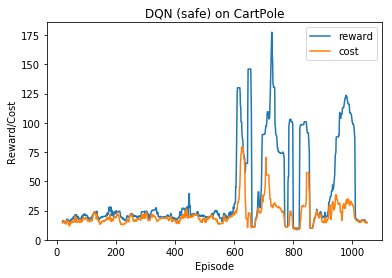

In [49]:
plt.figure()
plt.title('DQN (safe) on CartPole')
plt.plot(pd.DataFrame(r).rolling(20).median(), label = 'reward')
plt.plot(pd.DataFrame(c).rolling(20).median(), label = 'cost')
plt.xlabel('Episode')
plt.ylabel('Reward/Cost')
plt.savefig('sdqn.eps', bbox_inches = 'tight')
plt.legend()
plt.show()

Weird that the agent unlearns everything for some reason. What works and doesn't work:
1. Bellman (b) + JSD (j) + log_r for action selection - 
2. b log_r -
3. r log_r +- (goes up/down)
4. b + j log_pi no
5. r log_r log_r in R loss NO ??? also, reward doesn't go down with exploration?.. fixed when sampling argmax instead of sampling. For q-logits the policy should be argmax!, works
6. B log_r log_r argmax + (now -???..)
6. B+J log_r log_r argmax - ??? Why just adding a loss makes it worse? Are they scaled inappropriately? Or are they using the same layer making it follow two tasks? Want to be confident when solving this... It immediately made me solve this problems and spot the odd thing. It's so much more productive than monkey-coding. Why did I switch to it? It makes sense it doesn't work since I use soft Bellman loss
8. B log_r x 2 no common layer kinda, -

Hypothesis: experience replay is not implemented correctly. Check all equations. heck what target pi' is.

**19th May** I think it shouldn't work because soft bellman loss wouldn't work for q-logits which are approximately the same

Trying to make policy network to work...
1. Mistake in call to pulp: first argument was treated as name and not as Maximize
2. And it fucking works! ANd it stopped working again... Not sure what's the difference... Made separate optimizers -- didn't help. Added summaries (noticed that losses are of different magnitude)
3. Error in making JSD != Inf because used list == 0 instead of np.array == 0
4. Error in soft_bellman_loss: calculating gradient w.r.t. logits_policy too (don't need that)
5. Need to replace policy_new by policy in loss_r? Why is it different? It makes sense to train Q with argmaxQ policy and not on-policy...
6. Mistake: 10 batch size instead of 1000
7. q-function for R seems to blow up. Reducing expreplay to 1000 and updates to 100 like in DQN. Trying to decrease network size... +!!! And NO again... Nothing changed...
8. Hypothesis: q-function doesn't blow up, the norm is not computed properly. True. q-function is now correct... What if I act on it? Indeed, it works if I act on the Q-function. Maybe it means that I do too few updates for pi_new? Or that I run it for too few iterations? Or that Q-function converges only at 1000th iteration? Trying to make it converge faster by decreasing eps faster
9. If Q-function is optimized for 10 times, performance decreases. Splitting optimizers for Bellman and JSD and optimizing only JSD 10 times. Q-function converges after 500 train steps. Increasing the buffer size made it more stable! Trying to see the difference between policy and q_R. It's huge... Trying to track it... This thing doesn't go down much... Replacing it with MSE and running for 50 times doesn't help. Trying 150... Hypothesis: this happens because I use 0.01 in the loss.

**May 20th**

10. For some reason, pi --/-> q_R even if it's explicitly trained to match it. It just makes first component really small and the second close to 1... It starts fine but then makes first comonent 0 and that's it. It overfits to the data? So I make too _many_ iterations? No, 5 still makes it like this. Hypothesis: Q-learning should be done first with policy optimization only after, otherwise it goes way down? True. Only training after a certain step makes it better... Fixed the 0.01 in the LP. Very negative values have disappeared.. Fuck...
11. Switched to JSD. Adding more iterations for it... more iterations lead to overfit. Switched back to MSE. Training after q w/o changing q makes pi converge to q, even with softmax activation/wo it! WORKS even with JSD! HAVE WORKING pi, q_r!!!
12. Next steps: check q_T, q_D, q_L. They look CONVERGED in tensorboard... Enabling LP part...
13. LP constraint is often not satisfied at all...

TODO: check the equation for pi_k search. Read the paper on how to train all of that.

**21st of May**
Plotting the TF graph and checking that pi_k and qs arenot dependent on each other (why do they diverge together..)?

**A gap**
NeurIPS FT deadline...

**28th of May **
Need to add a safe baseline, otherwise the method cannot find a feasible solution!

In [50]:
len(get_rollout())

138

In [34]:
from tfshow import *

In [35]:
show_graph(tf.get_default_graph())

In [14]:
# see https://github.com/tensorflow/agents/blob/master/tf_agents/colabs/1_dqn_tutorial.ipynb
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [15]:
num_episodes = 3
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = env.reset()
    video.append_data(env.render(mode = 'rgb_array'))
    while not time_step.is_last():
      action_step = tf_agent.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(env.render())

embed_mp4(video_filename)

ValueError: invalid literal for int() with base 10: ''

In [32]:
!pip install imageio-ffmpeg

  Running setup.py bdist_wheel for imageio-ffmpeg ... done
  Stored in directory: /localhome/volodin/.cache/pip/wheels/54/ed/2d/4281f5e6a575bfaa7d8f1f4173a7cb635adc406c1f8d87bfc8
Successfully built imageio-ffmpeg
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [16]:
env.render(mode='rgb_array')

[autoreload of pyglet.gl.gl_info failed: Traceback (most recent call last):
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 374, in superreload
    module = reload(module)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/importlib/__init__.py", line 159, in reload
    name=parent_name) from None
ImportError: parent 'pyglet.gl' not in sys.modules
]


NameError: name 'base' is not defined

In [51]:
#env = env.unwrapped
#env = gym.wrappers.Monitor(env, './video')
#get_rollout()
#sess.run(params)
#tf.train.Saver().save(sess, './cartpole-h1.ckpt')
#tf.train.Saver().restore(sess, './cartpole-h1.ckpt')